In [21]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.api import qqplot,add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import warnings 
import graphviz
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import plot_importance
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.svm import SVC
from scipy.stats import expon, reciprocal
from sklearn.inspection import permutation_importance

matplotlib.rc("font", family="NanumGothic")
matplotlib.rc("axes", unicode_minus = False)

In [66]:
# !pip install catboost
# from catboost import CatBoostClassifier
# # from lightgbm import plot_importance 미지원

In [67]:
df_1= pd.read_csv("../data/actual_purchase.csv",index_col=0)
df_2= pd.read_csv("../data/Member_전처리.csv")
df_3= pd.read_csv("../data/Product_전처리.csv",index_col=0)
df_4= pd.read_csv("../data/날짜별 구매금액.csv")


# 애매한 식사대용 없애기
df_3[df_3['물품중분류']=='식사대용/기타']='밥종류'
df_3[df_3['물품중분류'] == '식빵, 식사대용'] = '식빵'

# 빈칸땜에 서로의 물품 헷갈림. 제거
df_3['물품중분류'] = df_3['물품중분류'].str.strip()
df_3['물품명'] = df_3['물품명'].str.strip()

df_merge = pd.merge(df_1,df_2,on='회원번호')
df_merge = pd.merge(df_merge,df_3,on='제품번호')

In [69]:
def get_age_group(age):
    if age < 30:
        return '20대'
    elif age < 40:
        return '30대'
    elif age < 50:
        return '40대'
    elif age < 60:
        return '50대'
    else:
        return '60대 이상'

# apply 메서드를 사용하여 나이를 기반으로 연령대 열 생성
df_2['연령대'] = df_2['나이'].apply(get_age_group)

In [71]:
df_2 = df_2.drop(columns=['회원상태','나이','등록카드','주소지'])

In [72]:
df1 = pd.read_csv('주문취소율포함.csv')
df2 = pd.read_csv('vip모델링.csv')

In [73]:
df2.loc[df2["연령대"]=="20대 이하","연령대"]="20대"
df2

,회원번호,성별,주소지,연령대,VIP
0,18764160,여,서울특별시,60대 이상,0
1,18792000,남,강원도,60대 이상,0
2,18942336,여,인천광역시,30대,1
3,18949760,여,강원도,60대 이상,0
4,19391488,여,대전광역시,50대,0
...,...,...,...,...,...
12323,1644772352,여,강원도,50대,0
12324,1644957952,여,부산광역시,30대,0
12325,1645334720,남,전라남도,20대,0
12326,1670400000,남,대구광역시,20대,0


In [33]:
# 취소율 하위 5프로 제거

In [77]:
df_marry = pd.merge(df2,df_2,on=['회원번호','성별','연령대'])

In [78]:
df_sorted = df1.sort_values(by='주문취소율', ascending=False)
total_rows = len(df_sorted)
bottom_5_percent = int(total_rows * 0.05)
df_sorted=df_sorted[:bottom_5_percent]
# 불량 고객임
df_sorted

,회원번호,구매수량,주문취소여부,주문취소율
5466,746648384,1.0,1,1.000000
3848,572744896,1.0,1,1.000000
4555,661251968,1.0,1,1.000000
4591,665622848,1.0,1,1.000000
10475,1322663552,1.0,1,1.000000
...,...,...,...,...
7319,888914496,15.0,2,0.133333
7934,978947200,15.0,2,0.133333
8697,1067003264,15.0,2,0.133333
1122,186824960,15.0,2,0.133333


In [79]:
# df_marry = df_marry[df_marry['결혼']!='미기입']

In [80]:
df_marry['연령대'].unique()

array(['60대 이상', '30대', '50대', '40대', '20대'], dtype=object)

In [81]:
df_marry.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12328 entries, 0 to 12327
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   회원번호    12328 non-null  int64 
 1   성별      12328 non-null  object
 2   주소지     12328 non-null  object
 3   연령대     12328 non-null  object
 4   VIP     12328 non-null  int64 
 5   결혼      12328 non-null  object
 6   구독여부    10032 non-null  object
 7   세부주소지   12328 non-null  object
dtypes: int64(2), object(6)
memory usage: 866.8+ KB


In [82]:
df_marry=df_marry.drop(columns=['주소지'],axis=1)
# df_2 = df_2.drop(columns=['회원상태','나이','등록카드','구독여부','주소지'])

In [83]:
df_marry = df_marry.drop(df_marry.index.intersection(df_sorted.index))

In [84]:
df_marry.to_csv('vip모델링(불량고객제거+결혼+세부주소지).csv',index=False)

In [343]:
# 불량 고객을 뺀 vip 여부데이터
df2 = df2.drop(df2.index.intersection(df_sorted.index))

In [344]:
df2.to_csv('vip모델링(불량고객제거).csv',index=False)

# 의사결정 나무

In [440]:
df = pd.read_csv('vip모델링(불량고객제거+결혼+세부주소지).csv')
df['성별'] = df['성별'].apply(lambda x: 0 if x == '여' else 1)
df = pd.get_dummies(df)

In [441]:
df_y = df["VIP"]
df_x = df.drop(["VIP",'회원번호'],axis=1, inplace = False)

df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_x,df_y,test_size=0.3, random_state=1234)

print("train data x size: {}".format(df_train_x.shape))
print("test data x size: {}".format(df_test_x.shape))
print("train data y size: {}".format(df_train_y.shape))
print("test data y size: {}".format(df_test_y.shape))

train data x size: (7235, 217)
test data x size: (3101, 217)
train data y size: (7235,)
test data y size: (3101,)


In [442]:
# 오버샘플링

from imblearn.over_sampling import SMOTE
#목표변수 빈도 확인
print(df.value_counts(["VIP"]),"\n")
print("VIP=1 비율",df.value_counts(df["VIP"]==1)/len(df))


VIP
0      9798
1       538
dtype: int64 

VIP=1 비율 VIP
False    0.947949
True     0.052051
dtype: float64


In [443]:
# over-sampling 설정
sm = SMOTE(sampling_strategy='auto')
# train데이터를 이용한 Over-sampling
x_resampled,y_resampled = sm.fit_resample(df_train_x,df_train_y)
#결과 확인
print('Over-Sampling 전:\n',df_train_y.value_counts(),"\n")
print('Over-Sampling 후 Train X: {}'.format(x_resampled.shape))
print('Over-Sampling 후 Train Y: {}\n'.format(y_resampled.shape))
print("Over-Sampling 후 '1':{}".format(sum(y_resampled==1)))
print("Over-Sampling 후 '0':{}".format(sum(y_resampled==0)))

Over-Sampling 전:
 0    6877
1     358
Name: VIP, dtype: int64 

Over-Sampling 후 Train X: (13754, 217)
Over-Sampling 후 Train Y: (13754,)

Over-Sampling 후 '1':6877
Over-Sampling 후 '0':6877


In [444]:
#데이터 결합
df_resampled = pd.concat([x_resampled,y_resampled], axis = 1)
print(df_resampled.head())

   성별  연령대_30대  연령대_40대  연령대_50대  연령대_60대 이상  결혼_기혼  결혼_미기입  결혼_미혼  \
0   0        0        0        1           0      1       0      0   
1   0        1        0        0           0      0       1      0   
2   0        1        0        0           0      0       1      0   
3   0        0        1        0           0      0       1      0   
4   0        1        0        0           0      1       0      0   

   구독여부_False  구독여부_True  ...  세부주소지_합천군  세부주소지_해남군  세부주소지_해운대구  세부주소지_홍성군  \
0           0          0  ...          0          0           0          0   
1           0          0  ...          0          0           0          0   
2           1          0  ...          0          0           0          0   
3           1          0  ...          0          0           0          0   
4           1          0  ...          0          0           0          0   

   세부주소지_홍천군  세부주소지_화성시  세부주소지_화순군  세부주소지_화천군  세부주소지_횡성군  VIP  
0          0          0          0          0 

In [445]:
df_train_x_over,df_test_x_over,df_train_y_over,df_test_y_over = train_test_split(x_resampled,y_resampled,test_size=0.3,
                                                                                stratify=y_resampled,random_state=1)
print('분할 전:',x_resampled.shape,"목표: ",y_resampled.shape)
print('분할 후 설명변수 현황 train:',df_train_x_over.shape,"test: ",df_test_x_over.shape)
print('분할 후 목표변수 현황 train:',df_train_y_over.value_counts(),"test: ",df_test_y_over.value_counts())

분할 전: (13754, 217) 목표:  (13754,)
분할 후 설명변수 현황 train: (9627, 217) test:  (4127, 217)
분할 후 목표변수 현황 train: 0    4814
1    4813
Name: VIP, dtype: int64 test:  1    2064
0    2063
Name: VIP, dtype: int64


In [446]:
tree_uncustomized = DecisionTreeClassifier(random_state=1)
tree_uncustomized.fit(df_train_x_over, df_train_y_over)

print("Score on training set: {:.3f}".format(tree_uncustomized.score(df_train_x_over, df_train_y_over)))
print("Score on test set: {:.3f}".format(tree_uncustomized.score(df_test_x_over, df_test_y_over)))

Score on training set: 0.975
Score on test set: 0.942


In [447]:
from sklearn.model_selection import RandomizedSearchCV

dt_clf = DecisionTreeClassifier(random_state=1)

param_dist = {
    'max_depth':[None,2,3,4,5,6,7,8,9], 
    }

tree_search = GridSearchCV(dt_clf, param_dist, scoring = 'accuracy', refit=True)
tree_search.fit(df_train_x_over, df_train_y_over)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=1),
             param_grid={'max_depth': [None, 2, 3, 4, 5, 6, 7, 8, 9]},
             scoring='accuracy')

In [448]:
print('best parameters : ', tree_search.best_params_)
print('best score : ', round(tree_search.best_score_, 4))

best parameters :  {'max_depth': None}
best score :  0.9384


In [449]:
v_feature_name = df_train_x_over.columns

df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["Importance"] = tree_search.best_estimator_.feature_importances_
# feature_importances=grid_search.best_estimator_.feature_importances_
df_importance.sort_values("Importance", ascending=False, inplace=True)
df_importance.round(3)

,Feature,Importance
8,구독여부_False,0.031
7,결혼_미혼,0.024
5,결혼_기혼,0.024
2,연령대_40대,0.017
4,연령대_60대 이상,0.016
...,...,...
17,세부주소지_강화군,0.000
24,세부주소지_고령군,0.000
140,세부주소지_영덕군,0.000
151,세부주소지_옥천군,0.000


Text(0, 0.5, '변수')

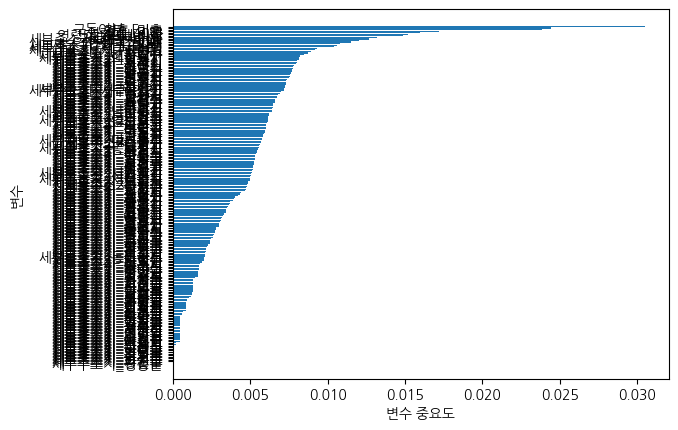

In [450]:
df_importance.sort_values("Importance",ascending=True, inplace=True)
coordinates = range(len(df_importance))
plt.barh(y=coordinates, width = df_importance["Importance"])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("변수 중요도")
plt.ylabel("변수")

In [451]:
from sklearn.metrics import classification_report
y_pred = tree_search.predict(df_train_x_over)
print('Train 예측/분류 결과')
print("Accuracy: {:.3f}\n".format(tree_search.score(df_train_x_over, df_train_y_over)))
print("Coufusion matrix: \n{}".format(confusion_matrix(df_train_y_over, y_pred)))

print(classification_report(df_train_y_over,y_pred,digits=3))

y_pred = tree_search.predict(df_test_x_over)
print('Test 예측/분류 결과')
print("Accuracy: {:.3f}\n".format(tree_search.score(df_test_x_over, df_test_y_over)))
print("Coufusion matrix: \n{}".format(confusion_matrix(df_test_y_over, y_pred)))

print(classification_report(df_test_y_over,y_pred,digits=3))

Train 예측/분류 결과
Accuracy: 0.975

Coufusion matrix: 
[[4751   63]
 [ 181 4632]]
              precision    recall  f1-score   support

           0      0.963     0.987     0.975      4814
           1      0.987     0.962     0.974      4813

    accuracy                          0.975      9627
   macro avg      0.975     0.975     0.975      9627
weighted avg      0.975     0.975     0.975      9627

Test 예측/분류 결과
Accuracy: 0.942

Coufusion matrix: 
[[1939  124]
 [ 114 1950]]
              precision    recall  f1-score   support

           0      0.944     0.940     0.942      2063
           1      0.940     0.945     0.942      2064

    accuracy                          0.942      4127
   macro avg      0.942     0.942     0.942      4127
weighted avg      0.942     0.942     0.942      4127



# 랜덤포레스트

In [452]:
df = pd.read_csv('vip모델링(불량고객제거+구독).csv')
df['성별'] = df['성별'].apply(lambda x: 0 if x == '여' else 1)
df = pd.get_dummies(df)

In [453]:
df_y = df["VIP"]
df_x = df.drop(["VIP",'회원번호'],axis=1, inplace = False)

df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_x,df_y,test_size=0.3, random_state=1234)

print("train data x size: {}".format(df_train_x.shape))
print("test data x size: {}".format(df_test_x.shape))
print("train data y size: {}".format(df_train_y.shape))
print("test data y size: {}".format(df_test_y.shape))

train data x size: (7235, 217)
test data x size: (3101, 217)
train data y size: (7235,)
test data y size: (3101,)


In [454]:
# 오버샘플링

from imblearn.over_sampling import SMOTE
#목표변수 빈도 확인
print(df.value_counts(["VIP"]),"\n")
print("VIP=1 비율",df.value_counts(df["VIP"]==1)/len(df))


VIP
0      9798
1       538
dtype: int64 

VIP=1 비율 VIP
False    0.947949
True     0.052051
dtype: float64


In [455]:
# over-sampling 설정
sm = SMOTE(sampling_strategy='auto')
# train데이터를 이용한 Over-sampling
x_resampled,y_resampled = sm.fit_resample(df_train_x,df_train_y)
#결과 확인
print('Over-Sampling 전:\n',df_train_y.value_counts(),"\n")
print('Over-Sampling 후 Train X: {}'.format(x_resampled.shape))
print('Over-Sampling 후 Train Y: {}\n'.format(y_resampled.shape))
print("Over-Sampling 후 '1':{}".format(sum(y_resampled==1)))
print("Over-Sampling 후 '0':{}".format(sum(y_resampled==0)))

Over-Sampling 전:
 0    6877
1     358
Name: VIP, dtype: int64 

Over-Sampling 후 Train X: (13754, 217)
Over-Sampling 후 Train Y: (13754,)

Over-Sampling 후 '1':6877
Over-Sampling 후 '0':6877


In [456]:
#데이터 결합
df_resampled = pd.concat([x_resampled,y_resampled], axis = 1)
print(df_resampled.head())

   성별  연령대_30대  연령대_40대  연령대_50대  연령대_60대 이상  결혼_기혼  결혼_미기입  결혼_미혼  \
0   0        0        0        1           0      1       0      0   
1   0        1        0        0           0      0       1      0   
2   0        1        0        0           0      0       1      0   
3   0        0        1        0           0      0       1      0   
4   0        1        0        0           0      1       0      0   

   구독여부_False  구독여부_True  ...  세부주소지_합천군  세부주소지_해남군  세부주소지_해운대구  세부주소지_홍성군  \
0           0          0  ...          0          0           0          0   
1           0          0  ...          0          0           0          0   
2           1          0  ...          0          0           0          0   
3           1          0  ...          0          0           0          0   
4           1          0  ...          0          0           0          0   

   세부주소지_홍천군  세부주소지_화성시  세부주소지_화순군  세부주소지_화천군  세부주소지_횡성군  VIP  
0          0          0          0          0 

In [457]:
df_train_x_over,df_test_x_over,df_train_y_over,df_test_y_over = train_test_split(x_resampled,y_resampled,test_size=0.3,
                                                                                stratify=y_resampled,random_state=1)
print('분할 전:',x_resampled.shape,"목표: ",y_resampled.shape)
print('분할 후 설명변수 현황 train:',df_train_x_over.shape,"test: ",df_test_x_over.shape)
print('분할 후 목표변수 현황 train:',df_train_y_over.value_counts(),"test: ",df_test_y_over.value_counts())

분할 전: (13754, 217) 목표:  (13754,)
분할 후 설명변수 현황 train: (9627, 217) test:  (4127, 217)
분할 후 목표변수 현황 train: 0    4814
1    4813
Name: VIP, dtype: int64 test:  1    2064
0    2063
Name: VIP, dtype: int64


In [458]:
from sklearn.model_selection import RandomizedSearchCV

dt_clf = RandomForestClassifier(random_state=1)

param_dist = {
    'n_estimators':[50,100,150],
    'max_depth':[None,2,3,4,5,6,7], 
    }

tree_search = GridSearchCV(dt_clf, param_dist, scoring = 'accuracy', refit=True)
tree_search.fit(df_train_x_over, df_train_y_over)

GridSearchCV(estimator=RandomForestClassifier(random_state=1),
             param_grid={'max_depth': [None, 2, 3, 4, 5, 6, 7],
                         'n_estimators': [50, 100, 150]},
             scoring='accuracy')

In [459]:
print('best parameters : ', tree_search.best_params_)
print('best score : ', round(tree_search.best_score_, 4))

best parameters :  {'max_depth': None, 'n_estimators': 150}
best score :  0.9313


In [460]:
v_feature_name = df_train_x_over.columns

df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["Importance"] = tree_search.best_estimator_.feature_importances_
# feature_importances=grid_search.best_estimator_.feature_importances_
df_importance.sort_values("Importance", ascending=False, inplace=True)
df_importance.round(3)

,Feature,Importance
8,구독여부_False,0.033
7,결혼_미혼,0.024
5,결혼_기혼,0.020
2,연령대_40대,0.018
1,연령대_30대,0.017
...,...,...
43,세부주소지_군위군,0.000
84,세부주소지_보성군,0.000
189,세부주소지_청송군,0.000
214,세부주소지_화순군,0.000


Text(0, 0.5, '변수')

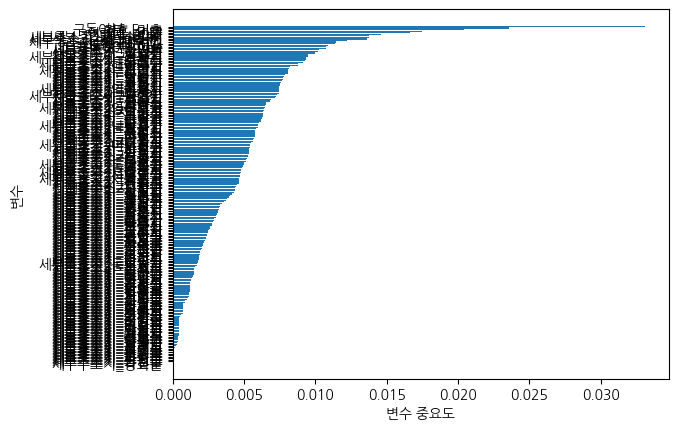

In [461]:
df_importance.sort_values("Importance",ascending=True, inplace=True)
coordinates = range(len(df_importance))
plt.barh(y=coordinates, width = df_importance["Importance"])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("변수 중요도")
plt.ylabel("변수")

In [462]:
from sklearn.metrics import classification_report
y_pred = tree_search.predict(df_train_x_over)
print('Train 예측/분류 결과')
print("Accuracy: {:.3f}\n".format(tree_search.score(df_train_x_over, df_train_y_over)))
print("Coufusion matrix: \n{}".format(confusion_matrix(df_train_y_over, y_pred)))

print(classification_report(df_train_y_over,y_pred,digits=3))

y_pred = tree_search.predict(df_test_x_over)
print('Test 예측/분류 결과')
print("Accuracy: {:.3f}\n".format(tree_search.score(df_test_x_over, df_test_y_over)))
print("Coufusion matrix: \n{}".format(confusion_matrix(df_test_y_over, y_pred)))

print(classification_report(df_test_y_over,y_pred,digits=3))

Train 예측/분류 결과
Accuracy: 0.973

Coufusion matrix: 
[[4727   87]
 [ 172 4641]]
              precision    recall  f1-score   support

           0      0.965     0.982     0.973      4814
           1      0.982     0.964     0.973      4813

    accuracy                          0.973      9627
   macro avg      0.973     0.973     0.973      9627
weighted avg      0.973     0.973     0.973      9627

Test 예측/분류 결과
Accuracy: 0.935

Coufusion matrix: 
[[1903  160]
 [ 109 1955]]
              precision    recall  f1-score   support

           0      0.946     0.922     0.934      2063
           1      0.924     0.947     0.936      2064

    accuracy                          0.935      4127
   macro avg      0.935     0.935     0.935      4127
weighted avg      0.935     0.935     0.935      4127



# 그래디언트 부스팅

In [463]:
df = pd.read_csv('vip모델링(불량고객제거+구독).csv')
df['성별'] = df['성별'].apply(lambda x: 0 if x == '여' else 1)
df = pd.get_dummies(df)

In [464]:
df_y = df["VIP"]
df_x = df.drop(["VIP",'회원번호'],axis=1, inplace = False)

df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_x,df_y,test_size=0.3, random_state=1234)

print("train data x size: {}".format(df_train_x.shape))
print("test data x size: {}".format(df_test_x.shape))
print("train data y size: {}".format(df_train_y.shape))
print("test data y size: {}".format(df_test_y.shape))

train data x size: (7235, 217)
test data x size: (3101, 217)
train data y size: (7235,)
test data y size: (3101,)


In [465]:
# 오버샘플링

from imblearn.over_sampling import SMOTE
#목표변수 빈도 확인
print(df.value_counts(["VIP"]),"\n")
print("VIP=1 비율",df.value_counts(df["VIP"]==1)/len(df))


VIP
0      9798
1       538
dtype: int64 

VIP=1 비율 VIP
False    0.947949
True     0.052051
dtype: float64


In [466]:
# over-sampling 설정
sm = SMOTE(sampling_strategy='auto')
# train데이터를 이용한 Over-sampling
x_resampled,y_resampled = sm.fit_resample(df_train_x,df_train_y)
#결과 확인
print('Over-Sampling 전:\n',df_train_y.value_counts(),"\n")
print('Over-Sampling 후 Train X: {}'.format(x_resampled.shape))
print('Over-Sampling 후 Train Y: {}\n'.format(y_resampled.shape))
print("Over-Sampling 후 '1':{}".format(sum(y_resampled==1)))
print("Over-Sampling 후 '0':{}".format(sum(y_resampled==0)))

Over-Sampling 전:
 0    6877
1     358
Name: VIP, dtype: int64 

Over-Sampling 후 Train X: (13754, 217)
Over-Sampling 후 Train Y: (13754,)

Over-Sampling 후 '1':6877
Over-Sampling 후 '0':6877


In [467]:
#데이터 결합
df_resampled = pd.concat([x_resampled,y_resampled], axis = 1)
print(df_resampled.head())

   성별  연령대_30대  연령대_40대  연령대_50대  연령대_60대 이상  결혼_기혼  결혼_미기입  결혼_미혼  \
0   0        0        0        1           0      1       0      0   
1   0        1        0        0           0      0       1      0   
2   0        1        0        0           0      0       1      0   
3   0        0        1        0           0      0       1      0   
4   0        1        0        0           0      1       0      0   

   구독여부_False  구독여부_True  ...  세부주소지_합천군  세부주소지_해남군  세부주소지_해운대구  세부주소지_홍성군  \
0           0          0  ...          0          0           0          0   
1           0          0  ...          0          0           0          0   
2           1          0  ...          0          0           0          0   
3           1          0  ...          0          0           0          0   
4           1          0  ...          0          0           0          0   

   세부주소지_홍천군  세부주소지_화성시  세부주소지_화순군  세부주소지_화천군  세부주소지_횡성군  VIP  
0          0          0          0          0 

In [468]:
df_train_x_over,df_test_x_over,df_train_y_over,df_test_y_over = train_test_split(x_resampled,y_resampled,test_size=0.3,
                                                                                stratify=y_resampled,random_state=1)
print('분할 전:',x_resampled.shape,"목표: ",y_resampled.shape)
print('분할 후 설명변수 현황 train:',df_train_x_over.shape,"test: ",df_test_x_over.shape)
print('분할 후 목표변수 현황 train:',df_train_y_over.value_counts(),"test: ",df_test_y_over.value_counts())

분할 전: (13754, 217) 목표:  (13754,)
분할 후 설명변수 현황 train: (9627, 217) test:  (4127, 217)
분할 후 목표변수 현황 train: 0    4814
1    4813
Name: VIP, dtype: int64 test:  1    2064
0    2063
Name: VIP, dtype: int64


In [469]:
from sklearn.model_selection import RandomizedSearchCV

dt_clf = GradientBoostingClassifier(random_state=1)

param_dist = {
    'max_depth':[None,2,3,4,5,6,7],
    'n_estimators' : [200,300,400]
    }

tree_search = GridSearchCV(dt_clf, param_dist, scoring = 'accuracy', refit=True)
tree_search.fit(df_train_x_over, df_train_y_over)

GridSearchCV(estimator=GradientBoostingClassifier(random_state=1),
             param_grid={'max_depth': [None, 2, 3, 4, 5, 6, 7],
                         'n_estimators': [200, 300, 400]},
             scoring='accuracy')

In [470]:
print('best parameters : ', tree_search.best_params_)
print('best score : ', round(tree_search.best_score_, 4))

best parameters :  {'max_depth': None, 'n_estimators': 200}
best score :  0.9394


In [471]:
v_feature_name = df_train_x_over.columns

df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["Importance"] = tree_search.best_estimator_.feature_importances_
# feature_importances=grid_search.best_estimator_.feature_importances_
df_importance.sort_values("Importance", ascending=False, inplace=True)
df_importance.round(3)

,Feature,Importance
8,구독여부_False,0.035
7,결혼_미혼,0.023
5,결혼_기혼,0.020
2,연령대_40대,0.018
1,연령대_30대,0.017
...,...,...
43,세부주소지_군위군,0.000
84,세부주소지_보성군,0.000
214,세부주소지_화순군,0.000
140,세부주소지_영덕군,0.000


Text(0, 0.5, '변수')

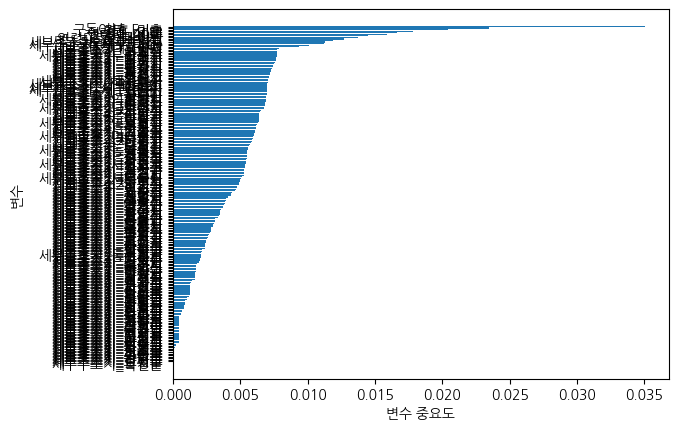

In [472]:
df_importance.sort_values("Importance",ascending=True, inplace=True)
coordinates = range(len(df_importance))
plt.barh(y=coordinates, width = df_importance["Importance"])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("변수 중요도")
plt.ylabel("변수")

In [473]:
from sklearn.metrics import classification_report
y_pred = tree_search.predict(df_train_x_over)
print('Train 예측/분류 결과')
print("Accuracy: {:.3f}\n".format(tree_search.score(df_train_x_over, df_train_y_over)))
print("Coufusion matrix: \n{}".format(confusion_matrix(df_train_y_over, y_pred)))

print(classification_report(df_train_y_over,y_pred,digits=3))

y_pred = tree_search.predict(df_test_x_over)
print('Test 예측/분류 결과')
print("Accuracy: {:.3f}\n".format(tree_search.score(df_test_x_over, df_test_y_over)))
print("Coufusion matrix: \n{}".format(confusion_matrix(df_test_y_over, y_pred)))

print(classification_report(df_test_y_over,y_pred,digits=3))

Train 예측/분류 결과
Accuracy: 0.974

Coufusion matrix: 
[[4748   66]
 [ 185 4628]]
              precision    recall  f1-score   support

           0      0.962     0.986     0.974      4814
           1      0.986     0.962     0.974      4813

    accuracy                          0.974      9627
   macro avg      0.974     0.974     0.974      9627
weighted avg      0.974     0.974     0.974      9627

Test 예측/분류 결과
Accuracy: 0.940

Coufusion matrix: 
[[1927  136]
 [ 112 1952]]
              precision    recall  f1-score   support

           0      0.945     0.934     0.940      2063
           1      0.935     0.946     0.940      2064

    accuracy                          0.940      4127
   macro avg      0.940     0.940     0.940      4127
weighted avg      0.940     0.940     0.940      4127



# XGBoost

In [475]:
df = pd.read_csv('vip모델링(불량고객제거+구독).csv')
df['성별'] = df['성별'].apply(lambda x: 0 if x == '여' else 1)
df = pd.get_dummies(df)

In [476]:
df_y = df["VIP"]
df_x = df.drop(["VIP",'회원번호'],axis=1, inplace = False)

df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_x,df_y,test_size=0.3, random_state=1234)

print("train data x size: {}".format(df_train_x.shape))
print("test data x size: {}".format(df_test_x.shape))
print("train data y size: {}".format(df_train_y.shape))
print("test data y size: {}".format(df_test_y.shape))

train data x size: (7235, 217)
test data x size: (3101, 217)
train data y size: (7235,)
test data y size: (3101,)


In [477]:
# 오버샘플링

from imblearn.over_sampling import SMOTE
#목표변수 빈도 확인
print(df.value_counts(["VIP"]),"\n")
print("VIP=1 비율",df.value_counts(df["VIP"]==1)/len(df))


VIP
0      9798
1       538
dtype: int64 

VIP=1 비율 VIP
False    0.947949
True     0.052051
dtype: float64


In [478]:
# over-sampling 설정
sm = SMOTE(sampling_strategy='auto')
# train데이터를 이용한 Over-sampling
x_resampled,y_resampled = sm.fit_resample(df_train_x,df_train_y)
#결과 확인
print('Over-Sampling 전:\n',df_train_y.value_counts(),"\n")
print('Over-Sampling 후 Train X: {}'.format(x_resampled.shape))
print('Over-Sampling 후 Train Y: {}\n'.format(y_resampled.shape))
print("Over-Sampling 후 '1':{}".format(sum(y_resampled==1)))
print("Over-Sampling 후 '0':{}".format(sum(y_resampled==0)))

Over-Sampling 전:
 0    6877
1     358
Name: VIP, dtype: int64 

Over-Sampling 후 Train X: (13754, 217)
Over-Sampling 후 Train Y: (13754,)

Over-Sampling 후 '1':6877
Over-Sampling 후 '0':6877


In [479]:
#데이터 결합
df_resampled = pd.concat([x_resampled,y_resampled], axis = 1)
print(df_resampled.head())

   성별  연령대_30대  연령대_40대  연령대_50대  연령대_60대 이상  결혼_기혼  결혼_미기입  결혼_미혼  \
0   0        0        0        1           0      1       0      0   
1   0        1        0        0           0      0       1      0   
2   0        1        0        0           0      0       1      0   
3   0        0        1        0           0      0       1      0   
4   0        1        0        0           0      1       0      0   

   구독여부_False  구독여부_True  ...  세부주소지_합천군  세부주소지_해남군  세부주소지_해운대구  세부주소지_홍성군  \
0           0          0  ...          0          0           0          0   
1           0          0  ...          0          0           0          0   
2           1          0  ...          0          0           0          0   
3           1          0  ...          0          0           0          0   
4           1          0  ...          0          0           0          0   

   세부주소지_홍천군  세부주소지_화성시  세부주소지_화순군  세부주소지_화천군  세부주소지_횡성군  VIP  
0          0          0          0          0 

In [480]:
df_train_x_over,df_test_x_over,df_train_y_over,df_test_y_over = train_test_split(x_resampled,y_resampled,test_size=0.3,
                                                                                stratify=y_resampled,random_state=1)
print('분할 전:',x_resampled.shape,"목표: ",y_resampled.shape)
print('분할 후 설명변수 현황 train:',df_train_x_over.shape,"test: ",df_test_x_over.shape)
print('분할 후 목표변수 현황 train:',df_train_y_over.value_counts(),"test: ",df_test_y_over.value_counts())

분할 전: (13754, 217) 목표:  (13754,)
분할 후 설명변수 현황 train: (9627, 217) test:  (4127, 217)
분할 후 목표변수 현황 train: 0    4814
1    4813
Name: VIP, dtype: int64 test:  1    2064
0    2063
Name: VIP, dtype: int64


In [483]:
dt_clf = XGBClassifier(random_state=1)

param_dist = {
    'tree_method': ['gpu_hist'],
    'max_depth':[None,5,6,7],
    'n_estimators':[300,400]
    }

tree_search = GridSearchCV(dt_clf, param_dist, scoring = 'accuracy', refit=True)
tree_search.fit(df_train_x_over, df_train_y_over)

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_b...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_

In [484]:
print('best parameters : ', tree_search.best_params_)
print('best score : ', round(tree_search.best_score_, 4))

best parameters :  {'max_depth': 7, 'n_estimators': 400, 'tree_method': 'gpu_hist'}
best score :  0.9337


In [485]:
v_feature_name = df_train_x_over.columns

df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["Importance"] = tree_search.best_estimator_.feature_importances_
# feature_importances=grid_search.best_estimator_.feature_importances_
df_importance.sort_values("Importance", ascending=False, inplace=True)
df_importance.round(3)

,Feature,Importance
118,세부주소지_수원시,0.018
0,성별,0.015
156,세부주소지_용인시,0.015
100,세부주소지_서구(대구),0.015
101,세부주소지_서구(대전),0.014
...,...,...
139,세부주소지_영광군,0.000
138,세부주소지_연천군,0.000
27,세부주소지_고창군,0.000
135,세부주소지_여주시,0.000


Text(0, 0.5, '변수')

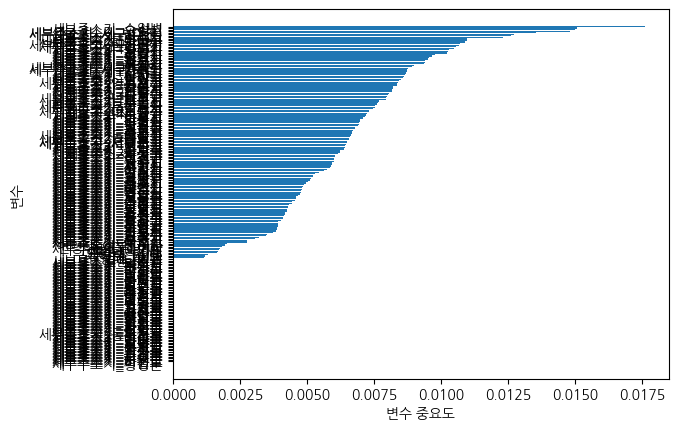

In [486]:
df_importance.sort_values("Importance",ascending=True, inplace=True)
coordinates = range(len(df_importance))
plt.barh(y=coordinates, width = df_importance["Importance"])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("변수 중요도")
plt.ylabel("변수")

In [487]:
from sklearn.metrics import classification_report
y_pred = tree_search.predict(df_train_x_over)
print('Train 예측/분류 결과')
print("Accuracy: {:.3f}\n".format(tree_search.score(df_train_x_over, df_train_y_over)))
print("Coufusion matrix: \n{}".format(confusion_matrix(df_train_y_over, y_pred)))

print(classification_report(df_train_y_over,y_pred,digits=3))

y_pred = tree_search.predict(df_test_x_over)
print('Test 예측/분류 결과')
print("Accuracy: {:.3f}\n".format(tree_search.score(df_test_x_over, df_test_y_over)))
print("Coufusion matrix: \n{}".format(confusion_matrix(df_test_y_over, y_pred)))

print(classification_report(df_test_y_over,y_pred,digits=3))

Train 예측/분류 결과
Accuracy: 0.952

Coufusion matrix: 
[[4579  235]
 [ 231 4582]]
              precision    recall  f1-score   support

           0      0.952     0.951     0.952      4814
           1      0.951     0.952     0.952      4813

    accuracy                          0.952      9627
   macro avg      0.952     0.952     0.952      9627
weighted avg      0.952     0.952     0.952      9627

Test 예측/분류 결과
Accuracy: 0.936

Coufusion matrix: 
[[1920  143]
 [ 121 1943]]
              precision    recall  f1-score   support

           0      0.941     0.931     0.936      2063
           1      0.931     0.941     0.936      2064

    accuracy                          0.936      4127
   macro avg      0.936     0.936     0.936      4127
weighted avg      0.936     0.936     0.936      4127



# catBoost

In [10]:
df = pd.read_csv('vip모델링(불량고객제거+구독).csv')
df['성별'] = df['성별'].apply(lambda x: 0 if x == '여' else 1)
df = pd.get_dummies(df)

In [11]:
df_y = df["VIP"]
df_x = df.drop(["VIP",'회원번호'],axis=1, inplace = False)

df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_x,df_y,test_size=0.3, random_state=1234)

print("train data x size: {}".format(df_train_x.shape))
print("test data x size: {}".format(df_test_x.shape))
print("train data y size: {}".format(df_train_y.shape))
print("test data y size: {}".format(df_test_y.shape))

train data x size: (7235, 217)
test data x size: (3101, 217)
train data y size: (7235,)
test data y size: (3101,)


In [12]:
# 오버샘플링

from imblearn.over_sampling import SMOTE
#목표변수 빈도 확인
print(df.value_counts(["VIP"]),"\n")
print("VIP=1 비율",df.value_counts(df["VIP"]==1)/len(df))


VIP
0      9798
1       538
dtype: int64 

VIP=1 비율 VIP
False    0.947949
True     0.052051
dtype: float64


In [13]:
# over-sampling 설정
sm = SMOTE(sampling_strategy='auto')
# train데이터를 이용한 Over-sampling
x_resampled,y_resampled = sm.fit_resample(df_train_x,df_train_y)
#결과 확인
print('Over-Sampling 전:\n',df_train_y.value_counts(),"\n")
print('Over-Sampling 후 Train X: {}'.format(x_resampled.shape))
print('Over-Sampling 후 Train Y: {}\n'.format(y_resampled.shape))
print("Over-Sampling 후 '1':{}".format(sum(y_resampled==1)))
print("Over-Sampling 후 '0':{}".format(sum(y_resampled==0)))

Over-Sampling 전:
 0    6877
1     358
Name: VIP, dtype: int64 

Over-Sampling 후 Train X: (13754, 217)
Over-Sampling 후 Train Y: (13754,)

Over-Sampling 후 '1':6877
Over-Sampling 후 '0':6877


In [14]:
#데이터 결합
df_resampled = pd.concat([x_resampled,y_resampled], axis = 1)
print(df_resampled.head())

   성별  연령대_30대  연령대_40대  연령대_50대  연령대_60대 이상  결혼_기혼  결혼_미기입  결혼_미혼  \
0   0        0        0        1           0      1       0      0   
1   0        1        0        0           0      0       1      0   
2   0        1        0        0           0      0       1      0   
3   0        0        1        0           0      0       1      0   
4   0        1        0        0           0      1       0      0   

   구독여부_False  구독여부_True  ...  세부주소지_합천군  세부주소지_해남군  세부주소지_해운대구  세부주소지_홍성군  \
0           0          0  ...          0          0           0          0   
1           0          0  ...          0          0           0          0   
2           1          0  ...          0          0           0          0   
3           1          0  ...          0          0           0          0   
4           1          0  ...          0          0           0          0   

   세부주소지_홍천군  세부주소지_화성시  세부주소지_화순군  세부주소지_화천군  세부주소지_횡성군  VIP  
0          0          0          0          0 

In [15]:
df_train_x_over,df_test_x_over,df_train_y_over,df_test_y_over = train_test_split(x_resampled,y_resampled,test_size=0.3,
                                                                                stratify=y_resampled,random_state=1)
print('분할 전:',x_resampled.shape,"목표: ",y_resampled.shape)
print('분할 후 설명변수 현황 train:',df_train_x_over.shape,"test: ",df_test_x_over.shape)
print('분할 후 목표변수 현황 train:',df_train_y_over.value_counts(),"test: ",df_test_y_over.value_counts())

분할 전: (13754, 217) 목표:  (13754,)
분할 후 설명변수 현황 train: (9627, 217) test:  (4127, 217)
분할 후 목표변수 현황 train: 0    4814
1    4813
Name: VIP, dtype: int64 test:  1    2064
0    2063
Name: VIP, dtype: int64


In [502]:
from catboost import CatBoostClassifier
dt_clf = CatBoostClassifier(random_state=1)

param_dist = {
    'task_type':['GPU'],
    'max_depth':[None,5,6,7],
    'n_estimators':[300,400]
    }

tree_search = GridSearchCV(dt_clf, param_dist, scoring = 'accuracy', refit=True)
tree_search.fit(df_train_x_over, df_train_y_over)

Learning rate set to 0.088616
0:	learn: 0.6882330	total: 4.92ms	remaining: 1.47s
1:	learn: 0.6832937	total: 7.77ms	remaining: 1.16s
2:	learn: 0.6780119	total: 10.5ms	remaining: 1.04s
3:	learn: 0.6742581	total: 13.2ms	remaining: 980ms
4:	learn: 0.6697223	total: 16ms	remaining: 943ms
5:	learn: 0.6656888	total: 18.7ms	remaining: 918ms
6:	learn: 0.6619680	total: 21.4ms	remaining: 897ms
7:	learn: 0.6573995	total: 24ms	remaining: 878ms
8:	learn: 0.6540756	total: 26.7ms	remaining: 862ms
9:	learn: 0.6508466	total: 29.3ms	remaining: 849ms
10:	learn: 0.6476940	total: 31.9ms	remaining: 837ms
11:	learn: 0.6451328	total: 35.7ms	remaining: 856ms
12:	learn: 0.6415331	total: 38.2ms	remaining: 843ms
13:	learn: 0.6387709	total: 41ms	remaining: 838ms
14:	learn: 0.6355226	total: 44.4ms	remaining: 844ms
15:	learn: 0.6326426	total: 49.2ms	remaining: 874ms
16:	learn: 0.6299841	total: 52.5ms	remaining: 874ms
17:	learn: 0.6275106	total: 55.3ms	remaining: 866ms
18:	learn: 0.6254364	total: 58ms	remaining: 858ms


195:	learn: 0.4042719	total: 534ms	remaining: 283ms
196:	learn: 0.4035315	total: 536ms	remaining: 280ms
197:	learn: 0.4030421	total: 539ms	remaining: 278ms
198:	learn: 0.4017679	total: 542ms	remaining: 275ms
199:	learn: 0.4005593	total: 544ms	remaining: 272ms
200:	learn: 0.3997100	total: 547ms	remaining: 269ms
201:	learn: 0.3990970	total: 549ms	remaining: 266ms
202:	learn: 0.3986715	total: 552ms	remaining: 264ms
203:	learn: 0.3978644	total: 554ms	remaining: 261ms
204:	learn: 0.3972733	total: 557ms	remaining: 258ms
205:	learn: 0.3961546	total: 559ms	remaining: 255ms
206:	learn: 0.3956648	total: 562ms	remaining: 252ms
207:	learn: 0.3947959	total: 564ms	remaining: 249ms
208:	learn: 0.3941636	total: 567ms	remaining: 247ms
209:	learn: 0.3936277	total: 570ms	remaining: 244ms
210:	learn: 0.3931017	total: 572ms	remaining: 241ms
211:	learn: 0.3924413	total: 575ms	remaining: 239ms
212:	learn: 0.3916944	total: 578ms	remaining: 236ms
213:	learn: 0.3908372	total: 581ms	remaining: 233ms
214:	learn: 

71:	learn: 0.5253989	total: 191ms	remaining: 605ms
72:	learn: 0.5229462	total: 194ms	remaining: 603ms
73:	learn: 0.5217414	total: 197ms	remaining: 600ms
74:	learn: 0.5205615	total: 199ms	remaining: 598ms
75:	learn: 0.5191954	total: 202ms	remaining: 595ms
76:	learn: 0.5179476	total: 204ms	remaining: 592ms
77:	learn: 0.5164414	total: 207ms	remaining: 589ms
78:	learn: 0.5152039	total: 210ms	remaining: 587ms
79:	learn: 0.5137341	total: 212ms	remaining: 584ms
80:	learn: 0.5122363	total: 215ms	remaining: 581ms
81:	learn: 0.5109710	total: 218ms	remaining: 579ms
82:	learn: 0.5089875	total: 220ms	remaining: 576ms
83:	learn: 0.5074875	total: 224ms	remaining: 576ms
84:	learn: 0.5062957	total: 227ms	remaining: 574ms
85:	learn: 0.5045864	total: 230ms	remaining: 571ms
86:	learn: 0.5034510	total: 232ms	remaining: 569ms
87:	learn: 0.5019363	total: 236ms	remaining: 568ms
88:	learn: 0.5005881	total: 239ms	remaining: 567ms
89:	learn: 0.4994615	total: 242ms	remaining: 564ms
90:	learn: 0.4984774	total: 245

293:	learn: 0.3454779	total: 791ms	remaining: 16.1ms
294:	learn: 0.3449744	total: 793ms	remaining: 13.4ms
295:	learn: 0.3447306	total: 796ms	remaining: 10.8ms
296:	learn: 0.3441576	total: 799ms	remaining: 8.07ms
297:	learn: 0.3435525	total: 801ms	remaining: 5.38ms
298:	learn: 0.3432525	total: 804ms	remaining: 2.69ms
299:	learn: 0.3425132	total: 807ms	remaining: 0us
Learning rate set to 0.088616
0:	learn: 0.6879937	total: 3.53ms	remaining: 1.05s
1:	learn: 0.6827846	total: 5.93ms	remaining: 883ms
2:	learn: 0.6774566	total: 8.27ms	remaining: 819ms
3:	learn: 0.6721003	total: 10.7ms	remaining: 789ms
4:	learn: 0.6678276	total: 13ms	remaining: 769ms
5:	learn: 0.6635901	total: 15.6ms	remaining: 764ms
6:	learn: 0.6602416	total: 18.2ms	remaining: 761ms
7:	learn: 0.6558866	total: 20.7ms	remaining: 754ms
8:	learn: 0.6522426	total: 23.2ms	remaining: 751ms
9:	learn: 0.6485096	total: 25.8ms	remaining: 748ms
10:	learn: 0.6443459	total: 28.3ms	remaining: 744ms
11:	learn: 0.6411030	total: 30.9ms	remaini

220:	learn: 0.3816808	total: 580ms	remaining: 207ms
221:	learn: 0.3806459	total: 582ms	remaining: 205ms
222:	learn: 0.3801580	total: 585ms	remaining: 202ms
223:	learn: 0.3797055	total: 588ms	remaining: 199ms
224:	learn: 0.3789943	total: 590ms	remaining: 197ms
225:	learn: 0.3785416	total: 593ms	remaining: 194ms
226:	learn: 0.3775126	total: 596ms	remaining: 192ms
227:	learn: 0.3767665	total: 598ms	remaining: 189ms
228:	learn: 0.3761803	total: 601ms	remaining: 186ms
229:	learn: 0.3756929	total: 603ms	remaining: 184ms
230:	learn: 0.3749909	total: 606ms	remaining: 181ms
231:	learn: 0.3745867	total: 609ms	remaining: 178ms
232:	learn: 0.3740167	total: 611ms	remaining: 176ms
233:	learn: 0.3729256	total: 614ms	remaining: 173ms
234:	learn: 0.3723675	total: 618ms	remaining: 171ms
235:	learn: 0.3719527	total: 622ms	remaining: 169ms
236:	learn: 0.3713928	total: 625ms	remaining: 166ms
237:	learn: 0.3707268	total: 628ms	remaining: 163ms
238:	learn: 0.3701220	total: 630ms	remaining: 161ms
239:	learn: 

124:	learn: 0.4635703	total: 369ms	remaining: 517ms
125:	learn: 0.4625838	total: 372ms	remaining: 514ms
126:	learn: 0.4617933	total: 375ms	remaining: 511ms
127:	learn: 0.4611782	total: 377ms	remaining: 507ms
128:	learn: 0.4598838	total: 380ms	remaining: 504ms
129:	learn: 0.4587996	total: 383ms	remaining: 501ms
130:	learn: 0.4577209	total: 386ms	remaining: 497ms
131:	learn: 0.4566879	total: 388ms	remaining: 494ms
132:	learn: 0.4559045	total: 391ms	remaining: 491ms
133:	learn: 0.4550150	total: 393ms	remaining: 487ms
134:	learn: 0.4542464	total: 396ms	remaining: 484ms
135:	learn: 0.4534815	total: 398ms	remaining: 480ms
136:	learn: 0.4526045	total: 401ms	remaining: 477ms
137:	learn: 0.4516649	total: 403ms	remaining: 473ms
138:	learn: 0.4508728	total: 406ms	remaining: 470ms
139:	learn: 0.4497784	total: 408ms	remaining: 466ms
140:	learn: 0.4466836	total: 411ms	remaining: 463ms
141:	learn: 0.4453097	total: 414ms	remaining: 460ms
142:	learn: 0.4445275	total: 417ms	remaining: 457ms
143:	learn: 

Learning rate set to 0.088616
0:	learn: 0.6862307	total: 3.39ms	remaining: 1.01s
1:	learn: 0.6807526	total: 5.8ms	remaining: 865ms
2:	learn: 0.6754024	total: 8.22ms	remaining: 814ms
3:	learn: 0.6705667	total: 10.6ms	remaining: 787ms
4:	learn: 0.6662634	total: 13ms	remaining: 768ms
5:	learn: 0.6628080	total: 15.6ms	remaining: 766ms
6:	learn: 0.6598733	total: 18.3ms	remaining: 765ms
7:	learn: 0.6557098	total: 20.9ms	remaining: 763ms
8:	learn: 0.6520931	total: 23.5ms	remaining: 760ms
9:	learn: 0.6484466	total: 26.2ms	remaining: 759ms
10:	learn: 0.6455110	total: 28.8ms	remaining: 757ms
11:	learn: 0.6426075	total: 31.4ms	remaining: 755ms
12:	learn: 0.6397860	total: 34.1ms	remaining: 752ms
13:	learn: 0.6366293	total: 36.7ms	remaining: 751ms
14:	learn: 0.6339815	total: 39.6ms	remaining: 753ms
15:	learn: 0.6314749	total: 42.3ms	remaining: 750ms
16:	learn: 0.6287990	total: 44.9ms	remaining: 747ms
17:	learn: 0.6257764	total: 47.5ms	remaining: 743ms
18:	learn: 0.6231538	total: 50.1ms	remaining: 7

209:	learn: 0.3927798	total: 573ms	remaining: 246ms
210:	learn: 0.3918782	total: 576ms	remaining: 243ms
211:	learn: 0.3912792	total: 578ms	remaining: 240ms
212:	learn: 0.3905940	total: 581ms	remaining: 237ms
213:	learn: 0.3900758	total: 584ms	remaining: 235ms
214:	learn: 0.3892822	total: 586ms	remaining: 232ms
215:	learn: 0.3885462	total: 589ms	remaining: 229ms
216:	learn: 0.3878612	total: 592ms	remaining: 226ms
217:	learn: 0.3874107	total: 594ms	remaining: 224ms
218:	learn: 0.3861879	total: 597ms	remaining: 221ms
219:	learn: 0.3852611	total: 600ms	remaining: 218ms
220:	learn: 0.3848159	total: 602ms	remaining: 215ms
221:	learn: 0.3839533	total: 605ms	remaining: 213ms
222:	learn: 0.3833490	total: 608ms	remaining: 210ms
223:	learn: 0.3827778	total: 610ms	remaining: 207ms
224:	learn: 0.3820512	total: 614ms	remaining: 205ms
225:	learn: 0.3814782	total: 618ms	remaining: 202ms
226:	learn: 0.3806391	total: 621ms	remaining: 200ms
227:	learn: 0.3801982	total: 623ms	remaining: 197ms
228:	learn: 

67:	learn: 0.5593758	total: 175ms	remaining: 853ms
68:	learn: 0.5580380	total: 177ms	remaining: 851ms
69:	learn: 0.5569760	total: 180ms	remaining: 849ms
70:	learn: 0.5559744	total: 183ms	remaining: 846ms
71:	learn: 0.5547002	total: 185ms	remaining: 844ms
72:	learn: 0.5533882	total: 188ms	remaining: 842ms
73:	learn: 0.5516865	total: 191ms	remaining: 839ms
74:	learn: 0.5506809	total: 193ms	remaining: 837ms
75:	learn: 0.5494480	total: 196ms	remaining: 835ms
76:	learn: 0.5478631	total: 198ms	remaining: 832ms
77:	learn: 0.5467906	total: 201ms	remaining: 832ms
78:	learn: 0.5455607	total: 205ms	remaining: 834ms
79:	learn: 0.5445343	total: 208ms	remaining: 834ms
80:	learn: 0.5434575	total: 211ms	remaining: 832ms
81:	learn: 0.5421356	total: 214ms	remaining: 830ms
82:	learn: 0.5399907	total: 217ms	remaining: 828ms
83:	learn: 0.5389552	total: 220ms	remaining: 827ms
84:	learn: 0.5381061	total: 223ms	remaining: 825ms
85:	learn: 0.5366936	total: 225ms	remaining: 822ms
86:	learn: 0.5356276	total: 228

288:	learn: 0.3884185	total: 772ms	remaining: 296ms
289:	learn: 0.3881863	total: 775ms	remaining: 294ms
290:	learn: 0.3879195	total: 777ms	remaining: 291ms
291:	learn: 0.3875008	total: 780ms	remaining: 288ms
292:	learn: 0.3866929	total: 782ms	remaining: 286ms
293:	learn: 0.3861073	total: 785ms	remaining: 283ms
294:	learn: 0.3857479	total: 788ms	remaining: 280ms
295:	learn: 0.3854835	total: 790ms	remaining: 278ms
296:	learn: 0.3849514	total: 793ms	remaining: 275ms
297:	learn: 0.3841487	total: 796ms	remaining: 272ms
298:	learn: 0.3837073	total: 798ms	remaining: 270ms
299:	learn: 0.3833531	total: 801ms	remaining: 267ms
300:	learn: 0.3829737	total: 804ms	remaining: 265ms
301:	learn: 0.3825809	total: 807ms	remaining: 262ms
302:	learn: 0.3819785	total: 810ms	remaining: 259ms
303:	learn: 0.3814994	total: 814ms	remaining: 257ms
304:	learn: 0.3807746	total: 817ms	remaining: 254ms
305:	learn: 0.3804561	total: 819ms	remaining: 252ms
306:	learn: 0.3799525	total: 822ms	remaining: 249ms
307:	learn: 

58:	learn: 0.5680263	total: 169ms	remaining: 976ms
59:	learn: 0.5665769	total: 172ms	remaining: 972ms
60:	learn: 0.5652570	total: 174ms	remaining: 968ms
61:	learn: 0.5640114	total: 177ms	remaining: 963ms
62:	learn: 0.5628669	total: 179ms	remaining: 959ms
63:	learn: 0.5617607	total: 182ms	remaining: 955ms
64:	learn: 0.5605200	total: 185ms	remaining: 951ms
65:	learn: 0.5593917	total: 187ms	remaining: 947ms
66:	learn: 0.5579491	total: 190ms	remaining: 943ms
67:	learn: 0.5566943	total: 192ms	remaining: 940ms
68:	learn: 0.5554720	total: 195ms	remaining: 936ms
69:	learn: 0.5544478	total: 198ms	remaining: 932ms
70:	learn: 0.5530828	total: 200ms	remaining: 929ms
71:	learn: 0.5516631	total: 203ms	remaining: 925ms
72:	learn: 0.5503749	total: 206ms	remaining: 921ms
73:	learn: 0.5492718	total: 208ms	remaining: 918ms
74:	learn: 0.5481431	total: 211ms	remaining: 914ms
75:	learn: 0.5466412	total: 213ms	remaining: 910ms
76:	learn: 0.5455011	total: 216ms	remaining: 907ms
77:	learn: 0.5441869	total: 220

284:	learn: 0.3885214	total: 769ms	remaining: 310ms
285:	learn: 0.3881104	total: 771ms	remaining: 307ms
286:	learn: 0.3874437	total: 774ms	remaining: 305ms
287:	learn: 0.3869972	total: 776ms	remaining: 302ms
288:	learn: 0.3866500	total: 779ms	remaining: 299ms
289:	learn: 0.3862872	total: 782ms	remaining: 297ms
290:	learn: 0.3859161	total: 784ms	remaining: 294ms
291:	learn: 0.3854527	total: 787ms	remaining: 291ms
292:	learn: 0.3848501	total: 790ms	remaining: 288ms
293:	learn: 0.3840990	total: 792ms	remaining: 286ms
294:	learn: 0.3837308	total: 795ms	remaining: 283ms
295:	learn: 0.3834736	total: 798ms	remaining: 280ms
296:	learn: 0.3828553	total: 801ms	remaining: 278ms
297:	learn: 0.3821195	total: 805ms	remaining: 275ms
298:	learn: 0.3817486	total: 807ms	remaining: 273ms
299:	learn: 0.3814178	total: 810ms	remaining: 270ms
300:	learn: 0.3810432	total: 813ms	remaining: 267ms
301:	learn: 0.3806339	total: 816ms	remaining: 265ms
302:	learn: 0.3801928	total: 819ms	remaining: 262ms
303:	learn: 

72:	learn: 0.5441806	total: 186ms	remaining: 835ms
73:	learn: 0.5428229	total: 189ms	remaining: 833ms
74:	learn: 0.5415475	total: 192ms	remaining: 830ms
75:	learn: 0.5405134	total: 194ms	remaining: 827ms
76:	learn: 0.5393376	total: 197ms	remaining: 824ms
77:	learn: 0.5380003	total: 199ms	remaining: 821ms
78:	learn: 0.5369893	total: 201ms	remaining: 819ms
79:	learn: 0.5358684	total: 204ms	remaining: 815ms
80:	learn: 0.5348575	total: 206ms	remaining: 812ms
81:	learn: 0.5339390	total: 209ms	remaining: 809ms
82:	learn: 0.5324522	total: 211ms	remaining: 806ms
83:	learn: 0.5315102	total: 213ms	remaining: 803ms
84:	learn: 0.5304607	total: 217ms	remaining: 803ms
85:	learn: 0.5294670	total: 219ms	remaining: 799ms
86:	learn: 0.5283642	total: 221ms	remaining: 796ms
87:	learn: 0.5270603	total: 224ms	remaining: 794ms
88:	learn: 0.5257591	total: 227ms	remaining: 793ms
89:	learn: 0.5246366	total: 230ms	remaining: 794ms
90:	learn: 0.5237542	total: 233ms	remaining: 791ms
91:	learn: 0.5230076	total: 236

291:	learn: 0.3806803	total: 784ms	remaining: 290ms
292:	learn: 0.3801439	total: 786ms	remaining: 287ms
293:	learn: 0.3797221	total: 789ms	remaining: 284ms
294:	learn: 0.3793543	total: 792ms	remaining: 282ms
295:	learn: 0.3787886	total: 794ms	remaining: 279ms
296:	learn: 0.3784849	total: 797ms	remaining: 276ms
297:	learn: 0.3780461	total: 799ms	remaining: 274ms
298:	learn: 0.3776117	total: 802ms	remaining: 271ms
299:	learn: 0.3770081	total: 805ms	remaining: 268ms
300:	learn: 0.3765208	total: 807ms	remaining: 266ms
301:	learn: 0.3760543	total: 810ms	remaining: 263ms
302:	learn: 0.3755709	total: 812ms	remaining: 260ms
303:	learn: 0.3751807	total: 815ms	remaining: 257ms
304:	learn: 0.3748891	total: 818ms	remaining: 255ms
305:	learn: 0.3743428	total: 822ms	remaining: 252ms
306:	learn: 0.3740006	total: 824ms	remaining: 250ms
307:	learn: 0.3735092	total: 827ms	remaining: 247ms
308:	learn: 0.3729110	total: 829ms	remaining: 244ms
309:	learn: 0.3725616	total: 832ms	remaining: 241ms
310:	learn: 

65:	learn: 0.5591800	total: 178ms	remaining: 899ms
66:	learn: 0.5580633	total: 180ms	remaining: 896ms
67:	learn: 0.5562031	total: 183ms	remaining: 893ms
68:	learn: 0.5549667	total: 186ms	remaining: 890ms
69:	learn: 0.5537245	total: 188ms	remaining: 887ms
70:	learn: 0.5525051	total: 191ms	remaining: 884ms
71:	learn: 0.5514775	total: 193ms	remaining: 881ms
72:	learn: 0.5501826	total: 196ms	remaining: 878ms
73:	learn: 0.5491296	total: 199ms	remaining: 875ms
74:	learn: 0.5476222	total: 201ms	remaining: 872ms
75:	learn: 0.5463226	total: 204ms	remaining: 870ms
76:	learn: 0.5450981	total: 207ms	remaining: 867ms
77:	learn: 0.5436739	total: 209ms	remaining: 864ms
78:	learn: 0.5422850	total: 212ms	remaining: 861ms
79:	learn: 0.5410549	total: 215ms	remaining: 861ms
80:	learn: 0.5400446	total: 219ms	remaining: 862ms
81:	learn: 0.5390915	total: 222ms	remaining: 862ms
82:	learn: 0.5373571	total: 225ms	remaining: 860ms
83:	learn: 0.5357245	total: 228ms	remaining: 858ms
84:	learn: 0.5347291	total: 231

285:	learn: 0.3907262	total: 775ms	remaining: 309ms
286:	learn: 0.3902842	total: 777ms	remaining: 306ms
287:	learn: 0.3899043	total: 780ms	remaining: 303ms
288:	learn: 0.3892861	total: 783ms	remaining: 301ms
289:	learn: 0.3889289	total: 785ms	remaining: 298ms
290:	learn: 0.3885747	total: 788ms	remaining: 295ms
291:	learn: 0.3881588	total: 791ms	remaining: 293ms
292:	learn: 0.3875650	total: 794ms	remaining: 290ms
293:	learn: 0.3871785	total: 796ms	remaining: 287ms
294:	learn: 0.3867511	total: 799ms	remaining: 284ms
295:	learn: 0.3864311	total: 802ms	remaining: 282ms
296:	learn: 0.3860833	total: 805ms	remaining: 279ms
297:	learn: 0.3857881	total: 809ms	remaining: 277ms
298:	learn: 0.3854721	total: 812ms	remaining: 274ms
299:	learn: 0.3850541	total: 815ms	remaining: 272ms
300:	learn: 0.3845047	total: 818ms	remaining: 269ms
301:	learn: 0.3840802	total: 821ms	remaining: 266ms
302:	learn: 0.3832222	total: 824ms	remaining: 264ms
303:	learn: 0.3828476	total: 827ms	remaining: 261ms
304:	learn: 

66:	learn: 0.5565843	total: 180ms	remaining: 893ms
67:	learn: 0.5553584	total: 182ms	remaining: 890ms
68:	learn: 0.5542219	total: 185ms	remaining: 887ms
69:	learn: 0.5528338	total: 188ms	remaining: 884ms
70:	learn: 0.5515283	total: 190ms	remaining: 881ms
71:	learn: 0.5500411	total: 193ms	remaining: 878ms
72:	learn: 0.5489210	total: 195ms	remaining: 875ms
73:	learn: 0.5477560	total: 198ms	remaining: 873ms
74:	learn: 0.5464984	total: 201ms	remaining: 869ms
75:	learn: 0.5453043	total: 203ms	remaining: 866ms
76:	learn: 0.5442576	total: 206ms	remaining: 863ms
77:	learn: 0.5429630	total: 208ms	remaining: 860ms
78:	learn: 0.5414619	total: 211ms	remaining: 858ms
79:	learn: 0.5404387	total: 214ms	remaining: 856ms
80:	learn: 0.5395917	total: 217ms	remaining: 853ms
81:	learn: 0.5380417	total: 219ms	remaining: 851ms
82:	learn: 0.5368302	total: 223ms	remaining: 851ms
83:	learn: 0.5357597	total: 225ms	remaining: 847ms
84:	learn: 0.5346431	total: 228ms	remaining: 844ms
85:	learn: 0.5334529	total: 230

294:	learn: 0.3837079	total: 774ms	remaining: 275ms
295:	learn: 0.3833072	total: 776ms	remaining: 273ms
296:	learn: 0.3829398	total: 779ms	remaining: 270ms
297:	learn: 0.3824814	total: 782ms	remaining: 268ms
298:	learn: 0.3818759	total: 784ms	remaining: 265ms
299:	learn: 0.3814966	total: 787ms	remaining: 262ms
300:	learn: 0.3810482	total: 790ms	remaining: 260ms
301:	learn: 0.3807340	total: 792ms	remaining: 257ms
302:	learn: 0.3803126	total: 795ms	remaining: 255ms
303:	learn: 0.3799774	total: 798ms	remaining: 252ms
304:	learn: 0.3795266	total: 800ms	remaining: 249ms
305:	learn: 0.3792215	total: 803ms	remaining: 247ms
306:	learn: 0.3786960	total: 806ms	remaining: 244ms
307:	learn: 0.3781695	total: 808ms	remaining: 241ms
308:	learn: 0.3776309	total: 811ms	remaining: 239ms
309:	learn: 0.3771458	total: 814ms	remaining: 236ms
310:	learn: 0.3767192	total: 817ms	remaining: 234ms
311:	learn: 0.3761891	total: 819ms	remaining: 231ms
312:	learn: 0.3758637	total: 822ms	remaining: 229ms
313:	learn: 

77:	learn: 0.5390473	total: 178ms	remaining: 506ms
78:	learn: 0.5379915	total: 180ms	remaining: 504ms
79:	learn: 0.5370912	total: 182ms	remaining: 502ms
80:	learn: 0.5358185	total: 185ms	remaining: 500ms
81:	learn: 0.5346084	total: 187ms	remaining: 498ms
82:	learn: 0.5332499	total: 189ms	remaining: 495ms
83:	learn: 0.5320433	total: 192ms	remaining: 493ms
84:	learn: 0.5309029	total: 194ms	remaining: 491ms
85:	learn: 0.5292036	total: 196ms	remaining: 489ms
86:	learn: 0.5282848	total: 199ms	remaining: 487ms
87:	learn: 0.5270698	total: 201ms	remaining: 484ms
88:	learn: 0.5257694	total: 203ms	remaining: 482ms
89:	learn: 0.5246383	total: 206ms	remaining: 481ms
90:	learn: 0.5236231	total: 209ms	remaining: 479ms
91:	learn: 0.5224850	total: 211ms	remaining: 477ms
92:	learn: 0.5215554	total: 213ms	remaining: 475ms
93:	learn: 0.5203299	total: 217ms	remaining: 476ms
94:	learn: 0.5193644	total: 220ms	remaining: 474ms
95:	learn: 0.5182279	total: 222ms	remaining: 472ms
96:	learn: 0.5173571	total: 224

247:	learn: 0.4012171	total: 576ms	remaining: 121ms
248:	learn: 0.4007504	total: 579ms	remaining: 119ms
249:	learn: 0.4001177	total: 581ms	remaining: 116ms
250:	learn: 0.3997422	total: 583ms	remaining: 114ms
251:	learn: 0.3991946	total: 586ms	remaining: 112ms
252:	learn: 0.3986456	total: 588ms	remaining: 109ms
253:	learn: 0.3974763	total: 590ms	remaining: 107ms
254:	learn: 0.3967540	total: 593ms	remaining: 105ms
255:	learn: 0.3964065	total: 595ms	remaining: 102ms
256:	learn: 0.3959846	total: 597ms	remaining: 100ms
257:	learn: 0.3956236	total: 600ms	remaining: 97.6ms
258:	learn: 0.3951707	total: 603ms	remaining: 95.4ms
259:	learn: 0.3945823	total: 605ms	remaining: 93.1ms
260:	learn: 0.3941282	total: 607ms	remaining: 90.8ms
261:	learn: 0.3936411	total: 611ms	remaining: 88.6ms
262:	learn: 0.3933329	total: 614ms	remaining: 86.3ms
263:	learn: 0.3928521	total: 616ms	remaining: 84ms
264:	learn: 0.3925485	total: 619ms	remaining: 81.7ms
265:	learn: 0.3922354	total: 621ms	remaining: 79.4ms
266:	

162:	learn: 0.4556362	total: 373ms	remaining: 313ms
163:	learn: 0.4547814	total: 375ms	remaining: 311ms
164:	learn: 0.4543167	total: 377ms	remaining: 309ms
165:	learn: 0.4534132	total: 380ms	remaining: 307ms
166:	learn: 0.4523925	total: 382ms	remaining: 304ms
167:	learn: 0.4518089	total: 385ms	remaining: 302ms
168:	learn: 0.4509512	total: 387ms	remaining: 300ms
169:	learn: 0.4500788	total: 389ms	remaining: 298ms
170:	learn: 0.4483364	total: 392ms	remaining: 295ms
171:	learn: 0.4477426	total: 394ms	remaining: 293ms
172:	learn: 0.4469585	total: 396ms	remaining: 291ms
173:	learn: 0.4463888	total: 398ms	remaining: 289ms
174:	learn: 0.4457366	total: 401ms	remaining: 286ms
175:	learn: 0.4451357	total: 403ms	remaining: 284ms
176:	learn: 0.4445327	total: 405ms	remaining: 281ms
177:	learn: 0.4436648	total: 408ms	remaining: 279ms
178:	learn: 0.4430450	total: 410ms	remaining: 277ms
179:	learn: 0.4423860	total: 413ms	remaining: 275ms
180:	learn: 0.4418163	total: 416ms	remaining: 273ms
181:	learn: 

74:	learn: 0.5371963	total: 174ms	remaining: 523ms
75:	learn: 0.5361999	total: 176ms	remaining: 520ms
76:	learn: 0.5349561	total: 179ms	remaining: 518ms
77:	learn: 0.5337566	total: 181ms	remaining: 515ms
78:	learn: 0.5326935	total: 183ms	remaining: 513ms
79:	learn: 0.5309798	total: 185ms	remaining: 510ms
80:	learn: 0.5300566	total: 188ms	remaining: 507ms
81:	learn: 0.5283012	total: 190ms	remaining: 505ms
82:	learn: 0.5270446	total: 192ms	remaining: 502ms
83:	learn: 0.5247162	total: 194ms	remaining: 500ms
84:	learn: 0.5238308	total: 196ms	remaining: 497ms
85:	learn: 0.5226701	total: 198ms	remaining: 494ms
86:	learn: 0.5216558	total: 201ms	remaining: 491ms
87:	learn: 0.5204414	total: 203ms	remaining: 488ms
88:	learn: 0.5193241	total: 205ms	remaining: 486ms
89:	learn: 0.5182079	total: 207ms	remaining: 483ms
90:	learn: 0.5171517	total: 209ms	remaining: 480ms
91:	learn: 0.5163256	total: 211ms	remaining: 478ms
92:	learn: 0.5151279	total: 213ms	remaining: 475ms
93:	learn: 0.5141777	total: 216

251:	learn: 0.3920924	total: 570ms	remaining: 109ms
252:	learn: 0.3916975	total: 572ms	remaining: 106ms
253:	learn: 0.3910859	total: 575ms	remaining: 104ms
254:	learn: 0.3906109	total: 577ms	remaining: 102ms
255:	learn: 0.3900448	total: 579ms	remaining: 99.5ms
256:	learn: 0.3894960	total: 581ms	remaining: 97.3ms
257:	learn: 0.3888261	total: 584ms	remaining: 95ms
258:	learn: 0.3881520	total: 586ms	remaining: 92.7ms
259:	learn: 0.3877795	total: 588ms	remaining: 90.5ms
260:	learn: 0.3872401	total: 591ms	remaining: 88.2ms
261:	learn: 0.3870317	total: 593ms	remaining: 86ms
262:	learn: 0.3865794	total: 596ms	remaining: 83.8ms
263:	learn: 0.3858634	total: 598ms	remaining: 81.5ms
264:	learn: 0.3851627	total: 601ms	remaining: 79.4ms
265:	learn: 0.3847793	total: 603ms	remaining: 77.1ms
266:	learn: 0.3843679	total: 605ms	remaining: 74.8ms
267:	learn: 0.3837884	total: 608ms	remaining: 72.6ms
268:	learn: 0.3835362	total: 610ms	remaining: 70.3ms
269:	learn: 0.3828987	total: 614ms	remaining: 68.2ms
2

165:	learn: 0.4549925	total: 381ms	remaining: 307ms
166:	learn: 0.4543451	total: 383ms	remaining: 305ms
167:	learn: 0.4536287	total: 385ms	remaining: 303ms
168:	learn: 0.4531020	total: 388ms	remaining: 300ms
169:	learn: 0.4523284	total: 390ms	remaining: 298ms
170:	learn: 0.4517622	total: 392ms	remaining: 296ms
171:	learn: 0.4508909	total: 395ms	remaining: 294ms
172:	learn: 0.4500316	total: 397ms	remaining: 291ms
173:	learn: 0.4493734	total: 399ms	remaining: 289ms
174:	learn: 0.4485722	total: 401ms	remaining: 287ms
175:	learn: 0.4480269	total: 404ms	remaining: 284ms
176:	learn: 0.4474321	total: 406ms	remaining: 282ms
177:	learn: 0.4467897	total: 408ms	remaining: 280ms
178:	learn: 0.4463544	total: 410ms	remaining: 277ms
179:	learn: 0.4448556	total: 414ms	remaining: 276ms
180:	learn: 0.4442027	total: 417ms	remaining: 274ms
181:	learn: 0.4435147	total: 420ms	remaining: 272ms
182:	learn: 0.4425294	total: 422ms	remaining: 270ms
183:	learn: 0.4413163	total: 424ms	remaining: 268ms
184:	learn: 

82:	learn: 0.5311774	total: 182ms	remaining: 476ms
83:	learn: 0.5301789	total: 184ms	remaining: 474ms
84:	learn: 0.5288165	total: 187ms	remaining: 472ms
85:	learn: 0.5277934	total: 189ms	remaining: 470ms
86:	learn: 0.5267600	total: 191ms	remaining: 468ms
87:	learn: 0.5257462	total: 193ms	remaining: 466ms
88:	learn: 0.5248355	total: 196ms	remaining: 464ms
89:	learn: 0.5229884	total: 198ms	remaining: 462ms
90:	learn: 0.5221067	total: 200ms	remaining: 460ms
91:	learn: 0.5204662	total: 203ms	remaining: 458ms
92:	learn: 0.5195503	total: 205ms	remaining: 456ms
93:	learn: 0.5182298	total: 207ms	remaining: 454ms
94:	learn: 0.5170947	total: 209ms	remaining: 452ms
95:	learn: 0.5163120	total: 212ms	remaining: 450ms
96:	learn: 0.5152023	total: 214ms	remaining: 448ms
97:	learn: 0.5140945	total: 217ms	remaining: 447ms
98:	learn: 0.5127327	total: 219ms	remaining: 445ms
99:	learn: 0.5116107	total: 222ms	remaining: 443ms
100:	learn: 0.5094261	total: 224ms	remaining: 441ms
101:	learn: 0.5075630	total: 2

254:	learn: 0.3953000	total: 580ms	remaining: 102ms
255:	learn: 0.3948073	total: 582ms	remaining: 100ms
256:	learn: 0.3941237	total: 584ms	remaining: 97.8ms
257:	learn: 0.3935412	total: 587ms	remaining: 95.5ms
258:	learn: 0.3930399	total: 589ms	remaining: 93.2ms
259:	learn: 0.3925254	total: 591ms	remaining: 91ms
260:	learn: 0.3916729	total: 594ms	remaining: 88.7ms
261:	learn: 0.3912613	total: 596ms	remaining: 86.5ms
262:	learn: 0.3906422	total: 599ms	remaining: 84.2ms
263:	learn: 0.3902034	total: 601ms	remaining: 82ms
264:	learn: 0.3897483	total: 603ms	remaining: 79.7ms
265:	learn: 0.3892268	total: 606ms	remaining: 77.5ms
266:	learn: 0.3888092	total: 609ms	remaining: 75.2ms
267:	learn: 0.3881486	total: 611ms	remaining: 73ms
268:	learn: 0.3878908	total: 614ms	remaining: 70.7ms
269:	learn: 0.3874686	total: 616ms	remaining: 68.5ms
270:	learn: 0.3868276	total: 619ms	remaining: 66.2ms
271:	learn: 0.3860375	total: 623ms	remaining: 64.1ms
272:	learn: 0.3855303	total: 625ms	remaining: 61.8ms
2

163:	learn: 0.4893568	total: 377ms	remaining: 543ms
164:	learn: 0.4889302	total: 380ms	remaining: 541ms
165:	learn: 0.4882104	total: 382ms	remaining: 539ms
166:	learn: 0.4876724	total: 384ms	remaining: 536ms
167:	learn: 0.4870496	total: 387ms	remaining: 534ms
168:	learn: 0.4862663	total: 389ms	remaining: 532ms
169:	learn: 0.4855761	total: 391ms	remaining: 529ms
170:	learn: 0.4849552	total: 394ms	remaining: 527ms
171:	learn: 0.4844093	total: 396ms	remaining: 525ms
172:	learn: 0.4838137	total: 398ms	remaining: 522ms
173:	learn: 0.4831940	total: 400ms	remaining: 520ms
174:	learn: 0.4825566	total: 403ms	remaining: 518ms
175:	learn: 0.4818296	total: 405ms	remaining: 515ms
176:	learn: 0.4810670	total: 408ms	remaining: 514ms
177:	learn: 0.4798339	total: 412ms	remaining: 513ms
178:	learn: 0.4791768	total: 414ms	remaining: 511ms
179:	learn: 0.4784981	total: 417ms	remaining: 509ms
180:	learn: 0.4777879	total: 419ms	remaining: 507ms
181:	learn: 0.4770501	total: 421ms	remaining: 505ms
182:	learn: 

328:	learn: 0.3997098	total: 776ms	remaining: 168ms
329:	learn: 0.3991918	total: 779ms	remaining: 165ms
330:	learn: 0.3987993	total: 781ms	remaining: 163ms
331:	learn: 0.3982488	total: 783ms	remaining: 160ms
332:	learn: 0.3979133	total: 786ms	remaining: 158ms
333:	learn: 0.3975212	total: 788ms	remaining: 156ms
334:	learn: 0.3970587	total: 790ms	remaining: 153ms
335:	learn: 0.3965950	total: 792ms	remaining: 151ms
336:	learn: 0.3959518	total: 795ms	remaining: 149ms
337:	learn: 0.3953825	total: 797ms	remaining: 146ms
338:	learn: 0.3950333	total: 799ms	remaining: 144ms
339:	learn: 0.3946411	total: 802ms	remaining: 141ms
340:	learn: 0.3938778	total: 804ms	remaining: 139ms
341:	learn: 0.3936136	total: 807ms	remaining: 137ms
342:	learn: 0.3933202	total: 809ms	remaining: 134ms
343:	learn: 0.3929651	total: 812ms	remaining: 132ms
344:	learn: 0.3925092	total: 814ms	remaining: 130ms
345:	learn: 0.3922852	total: 816ms	remaining: 127ms
346:	learn: 0.3920235	total: 819ms	remaining: 125ms
347:	learn: 

164:	learn: 0.4872701	total: 383ms	remaining: 545ms
165:	learn: 0.4866013	total: 385ms	remaining: 543ms
166:	learn: 0.4858958	total: 387ms	remaining: 540ms
167:	learn: 0.4853227	total: 390ms	remaining: 538ms
168:	learn: 0.4846285	total: 392ms	remaining: 536ms
169:	learn: 0.4837546	total: 394ms	remaining: 534ms
170:	learn: 0.4825845	total: 397ms	remaining: 531ms
171:	learn: 0.4820485	total: 399ms	remaining: 529ms
172:	learn: 0.4814334	total: 401ms	remaining: 527ms
173:	learn: 0.4809253	total: 404ms	remaining: 524ms
174:	learn: 0.4802665	total: 406ms	remaining: 522ms
175:	learn: 0.4796715	total: 408ms	remaining: 520ms
176:	learn: 0.4790159	total: 411ms	remaining: 517ms
177:	learn: 0.4783508	total: 413ms	remaining: 515ms
178:	learn: 0.4776735	total: 416ms	remaining: 514ms
179:	learn: 0.4772248	total: 418ms	remaining: 511ms
180:	learn: 0.4767706	total: 421ms	remaining: 509ms
181:	learn: 0.4762039	total: 423ms	remaining: 507ms
182:	learn: 0.4754131	total: 426ms	remaining: 505ms
183:	learn: 

332:	learn: 0.3988475	total: 782ms	remaining: 157ms
333:	learn: 0.3984588	total: 785ms	remaining: 155ms
334:	learn: 0.3981678	total: 787ms	remaining: 153ms
335:	learn: 0.3977914	total: 790ms	remaining: 150ms
336:	learn: 0.3972773	total: 792ms	remaining: 148ms
337:	learn: 0.3969952	total: 794ms	remaining: 146ms
338:	learn: 0.3965267	total: 796ms	remaining: 143ms
339:	learn: 0.3960222	total: 799ms	remaining: 141ms
340:	learn: 0.3955673	total: 801ms	remaining: 139ms
341:	learn: 0.3951326	total: 803ms	remaining: 136ms
342:	learn: 0.3948365	total: 806ms	remaining: 134ms
343:	learn: 0.3946229	total: 809ms	remaining: 132ms
344:	learn: 0.3940903	total: 811ms	remaining: 129ms
345:	learn: 0.3938050	total: 813ms	remaining: 127ms
346:	learn: 0.3935169	total: 816ms	remaining: 125ms
347:	learn: 0.3931197	total: 819ms	remaining: 122ms
348:	learn: 0.3929149	total: 821ms	remaining: 120ms
349:	learn: 0.3926437	total: 825ms	remaining: 118ms
350:	learn: 0.3921494	total: 827ms	remaining: 115ms
351:	learn: 

163:	learn: 0.4830020	total: 381ms	remaining: 548ms
164:	learn: 0.4822297	total: 383ms	remaining: 546ms
165:	learn: 0.4814928	total: 386ms	remaining: 544ms
166:	learn: 0.4806578	total: 388ms	remaining: 541ms
167:	learn: 0.4801131	total: 390ms	remaining: 539ms
168:	learn: 0.4793629	total: 393ms	remaining: 537ms
169:	learn: 0.4788822	total: 395ms	remaining: 534ms
170:	learn: 0.4783108	total: 397ms	remaining: 532ms
171:	learn: 0.4777121	total: 399ms	remaining: 529ms
172:	learn: 0.4769671	total: 402ms	remaining: 527ms
173:	learn: 0.4764550	total: 404ms	remaining: 525ms
174:	learn: 0.4756762	total: 406ms	remaining: 522ms
175:	learn: 0.4751013	total: 409ms	remaining: 520ms
176:	learn: 0.4745045	total: 411ms	remaining: 518ms
177:	learn: 0.4737673	total: 414ms	remaining: 516ms
178:	learn: 0.4732149	total: 416ms	remaining: 514ms
179:	learn: 0.4725592	total: 419ms	remaining: 512ms
180:	learn: 0.4718440	total: 421ms	remaining: 509ms
181:	learn: 0.4712547	total: 424ms	remaining: 508ms
182:	learn: 

337:	learn: 0.3893615	total: 780ms	remaining: 143ms
338:	learn: 0.3890437	total: 782ms	remaining: 141ms
339:	learn: 0.3887208	total: 784ms	remaining: 138ms
340:	learn: 0.3882932	total: 787ms	remaining: 136ms
341:	learn: 0.3879713	total: 789ms	remaining: 134ms
342:	learn: 0.3874519	total: 791ms	remaining: 131ms
343:	learn: 0.3871479	total: 793ms	remaining: 129ms
344:	learn: 0.3865072	total: 796ms	remaining: 127ms
345:	learn: 0.3861273	total: 798ms	remaining: 125ms
346:	learn: 0.3858946	total: 800ms	remaining: 122ms
347:	learn: 0.3854724	total: 803ms	remaining: 120ms
348:	learn: 0.3850944	total: 805ms	remaining: 118ms
349:	learn: 0.3846586	total: 808ms	remaining: 115ms
350:	learn: 0.3841166	total: 810ms	remaining: 113ms
351:	learn: 0.3837982	total: 812ms	remaining: 111ms
352:	learn: 0.3833716	total: 815ms	remaining: 109ms
353:	learn: 0.3830972	total: 819ms	remaining: 106ms
354:	learn: 0.3827252	total: 821ms	remaining: 104ms
355:	learn: 0.3824021	total: 824ms	remaining: 102ms
356:	learn: 

163:	learn: 0.4876031	total: 382ms	remaining: 550ms
164:	learn: 0.4868585	total: 384ms	remaining: 547ms
165:	learn: 0.4862886	total: 386ms	remaining: 545ms
166:	learn: 0.4854424	total: 389ms	remaining: 542ms
167:	learn: 0.4847379	total: 391ms	remaining: 540ms
168:	learn: 0.4839317	total: 393ms	remaining: 538ms
169:	learn: 0.4832914	total: 396ms	remaining: 535ms
170:	learn: 0.4825729	total: 398ms	remaining: 533ms
171:	learn: 0.4818292	total: 400ms	remaining: 531ms
172:	learn: 0.4812307	total: 403ms	remaining: 528ms
173:	learn: 0.4806479	total: 405ms	remaining: 526ms
174:	learn: 0.4801350	total: 407ms	remaining: 524ms
175:	learn: 0.4794892	total: 409ms	remaining: 521ms
176:	learn: 0.4788191	total: 412ms	remaining: 519ms
177:	learn: 0.4783941	total: 415ms	remaining: 517ms
178:	learn: 0.4777775	total: 418ms	remaining: 516ms
179:	learn: 0.4764454	total: 421ms	remaining: 515ms
180:	learn: 0.4757391	total: 424ms	remaining: 512ms
181:	learn: 0.4751175	total: 426ms	remaining: 510ms
182:	learn: 

333:	learn: 0.3988722	total: 781ms	remaining: 154ms
334:	learn: 0.3984419	total: 783ms	remaining: 152ms
335:	learn: 0.3979782	total: 785ms	remaining: 150ms
336:	learn: 0.3976999	total: 788ms	remaining: 147ms
337:	learn: 0.3975354	total: 790ms	remaining: 145ms
338:	learn: 0.3971325	total: 792ms	remaining: 143ms
339:	learn: 0.3967951	total: 794ms	remaining: 140ms
340:	learn: 0.3964345	total: 797ms	remaining: 138ms
341:	learn: 0.3960519	total: 799ms	remaining: 135ms
342:	learn: 0.3952193	total: 801ms	remaining: 133ms
343:	learn: 0.3947001	total: 804ms	remaining: 131ms
344:	learn: 0.3943017	total: 806ms	remaining: 128ms
345:	learn: 0.3940245	total: 809ms	remaining: 126ms
346:	learn: 0.3936371	total: 811ms	remaining: 124ms
347:	learn: 0.3930502	total: 815ms	remaining: 122ms
348:	learn: 0.3925556	total: 817ms	remaining: 119ms
349:	learn: 0.3922623	total: 820ms	remaining: 117ms
350:	learn: 0.3916168	total: 822ms	remaining: 115ms
351:	learn: 0.3914046	total: 825ms	remaining: 112ms
352:	learn: 

166:	learn: 0.4859220	total: 375ms	remaining: 524ms
167:	learn: 0.4852158	total: 378ms	remaining: 521ms
168:	learn: 0.4847328	total: 380ms	remaining: 519ms
169:	learn: 0.4835338	total: 382ms	remaining: 516ms
170:	learn: 0.4827501	total: 383ms	remaining: 513ms
171:	learn: 0.4821627	total: 385ms	remaining: 511ms
172:	learn: 0.4812114	total: 387ms	remaining: 508ms
173:	learn: 0.4807146	total: 389ms	remaining: 506ms
174:	learn: 0.4801119	total: 391ms	remaining: 503ms
175:	learn: 0.4796140	total: 393ms	remaining: 500ms
176:	learn: 0.4787681	total: 395ms	remaining: 498ms
177:	learn: 0.4781614	total: 398ms	remaining: 497ms
178:	learn: 0.4774642	total: 401ms	remaining: 495ms
179:	learn: 0.4769829	total: 403ms	remaining: 493ms
180:	learn: 0.4763728	total: 406ms	remaining: 491ms
181:	learn: 0.4757650	total: 408ms	remaining: 489ms
182:	learn: 0.4751424	total: 411ms	remaining: 487ms
183:	learn: 0.4744397	total: 414ms	remaining: 487ms
184:	learn: 0.4738703	total: 417ms	remaining: 485ms
185:	learn: 

336:	learn: 0.3955309	total: 773ms	remaining: 145ms
337:	learn: 0.3953489	total: 776ms	remaining: 142ms
338:	learn: 0.3949113	total: 778ms	remaining: 140ms
339:	learn: 0.3947178	total: 780ms	remaining: 138ms
340:	learn: 0.3943918	total: 783ms	remaining: 135ms
341:	learn: 0.3940007	total: 785ms	remaining: 133ms
342:	learn: 0.3935315	total: 787ms	remaining: 131ms
343:	learn: 0.3932470	total: 790ms	remaining: 129ms
344:	learn: 0.3927856	total: 792ms	remaining: 126ms
345:	learn: 0.3925057	total: 795ms	remaining: 124ms
346:	learn: 0.3923152	total: 797ms	remaining: 122ms
347:	learn: 0.3917652	total: 799ms	remaining: 119ms
348:	learn: 0.3914549	total: 802ms	remaining: 117ms
349:	learn: 0.3911785	total: 804ms	remaining: 115ms
350:	learn: 0.3905946	total: 808ms	remaining: 113ms
351:	learn: 0.3899983	total: 811ms	remaining: 111ms
352:	learn: 0.3897542	total: 813ms	remaining: 108ms
353:	learn: 0.3894493	total: 816ms	remaining: 106ms
354:	learn: 0.3891928	total: 818ms	remaining: 104ms
355:	learn: 

142:	learn: 0.4465025	total: 373ms	remaining: 409ms
143:	learn: 0.4457137	total: 375ms	remaining: 406ms
144:	learn: 0.4448881	total: 378ms	remaining: 404ms
145:	learn: 0.4438742	total: 380ms	remaining: 401ms
146:	learn: 0.4431951	total: 383ms	remaining: 398ms
147:	learn: 0.4422196	total: 385ms	remaining: 396ms
148:	learn: 0.4412176	total: 388ms	remaining: 393ms
149:	learn: 0.4406751	total: 391ms	remaining: 391ms
150:	learn: 0.4397322	total: 393ms	remaining: 388ms
151:	learn: 0.4389966	total: 396ms	remaining: 385ms
152:	learn: 0.4381092	total: 398ms	remaining: 383ms
153:	learn: 0.4371486	total: 401ms	remaining: 380ms
154:	learn: 0.4362731	total: 404ms	remaining: 378ms
155:	learn: 0.4333896	total: 408ms	remaining: 376ms
156:	learn: 0.4325318	total: 411ms	remaining: 374ms
157:	learn: 0.4316129	total: 414ms	remaining: 372ms
158:	learn: 0.4308332	total: 416ms	remaining: 369ms
159:	learn: 0.4302085	total: 419ms	remaining: 366ms
160:	learn: 0.4294766	total: 422ms	remaining: 364ms
161:	learn: 

Learning rate set to 0.088616
0:	learn: 0.6863217	total: 3.33ms	remaining: 997ms
1:	learn: 0.6808638	total: 5.89ms	remaining: 877ms
2:	learn: 0.6756070	total: 8.44ms	remaining: 835ms
3:	learn: 0.6720741	total: 11ms	remaining: 813ms
4:	learn: 0.6676624	total: 13.5ms	remaining: 799ms
5:	learn: 0.6636086	total: 16.2ms	remaining: 793ms
6:	learn: 0.6596931	total: 18.7ms	remaining: 783ms
7:	learn: 0.6549725	total: 21.2ms	remaining: 773ms
8:	learn: 0.6514320	total: 23.7ms	remaining: 767ms
9:	learn: 0.6475626	total: 26.3ms	remaining: 763ms
10:	learn: 0.6442464	total: 28.8ms	remaining: 757ms
11:	learn: 0.6411379	total: 31.3ms	remaining: 751ms
12:	learn: 0.6379564	total: 33.8ms	remaining: 747ms
13:	learn: 0.6356307	total: 36.4ms	remaining: 743ms
14:	learn: 0.6332341	total: 38.9ms	remaining: 740ms
15:	learn: 0.6307193	total: 41.4ms	remaining: 735ms
16:	learn: 0.6279883	total: 43.9ms	remaining: 731ms
17:	learn: 0.6254409	total: 46.4ms	remaining: 728ms
18:	learn: 0.6231919	total: 49ms	remaining: 72

217:	learn: 0.3880429	total: 590ms	remaining: 222ms
218:	learn: 0.3874982	total: 592ms	remaining: 219ms
219:	learn: 0.3870830	total: 595ms	remaining: 216ms
220:	learn: 0.3865307	total: 597ms	remaining: 213ms
221:	learn: 0.3860003	total: 599ms	remaining: 211ms
222:	learn: 0.3853978	total: 601ms	remaining: 208ms
223:	learn: 0.3848884	total: 604ms	remaining: 205ms
224:	learn: 0.3841289	total: 606ms	remaining: 202ms
225:	learn: 0.3836959	total: 608ms	remaining: 199ms
226:	learn: 0.3829577	total: 611ms	remaining: 196ms
227:	learn: 0.3803541	total: 613ms	remaining: 194ms
228:	learn: 0.3800178	total: 616ms	remaining: 191ms
229:	learn: 0.3793624	total: 619ms	remaining: 188ms
230:	learn: 0.3787786	total: 622ms	remaining: 186ms
231:	learn: 0.3782427	total: 624ms	remaining: 183ms
232:	learn: 0.3775527	total: 627ms	remaining: 180ms
233:	learn: 0.3769808	total: 631ms	remaining: 178ms
234:	learn: 0.3765537	total: 634ms	remaining: 175ms
235:	learn: 0.3759277	total: 637ms	remaining: 173ms
236:	learn: 

145:	learn: 0.4384672	total: 386ms	remaining: 407ms
146:	learn: 0.4375650	total: 388ms	remaining: 404ms
147:	learn: 0.4365929	total: 391ms	remaining: 402ms
148:	learn: 0.4358076	total: 394ms	remaining: 399ms
149:	learn: 0.4350894	total: 396ms	remaining: 396ms
150:	learn: 0.4344019	total: 399ms	remaining: 394ms
151:	learn: 0.4336262	total: 402ms	remaining: 391ms
152:	learn: 0.4328943	total: 404ms	remaining: 388ms
153:	learn: 0.4322159	total: 407ms	remaining: 386ms
154:	learn: 0.4315325	total: 410ms	remaining: 383ms
155:	learn: 0.4305158	total: 412ms	remaining: 380ms
156:	learn: 0.4296329	total: 415ms	remaining: 378ms
157:	learn: 0.4289037	total: 417ms	remaining: 375ms
158:	learn: 0.4277303	total: 420ms	remaining: 372ms
159:	learn: 0.4266218	total: 423ms	remaining: 370ms
160:	learn: 0.4261040	total: 426ms	remaining: 367ms
161:	learn: 0.4250567	total: 428ms	remaining: 365ms
162:	learn: 0.4245735	total: 431ms	remaining: 362ms
163:	learn: 0.4238729	total: 434ms	remaining: 360ms
164:	learn: 

74:	learn: 0.5209846	total: 192ms	remaining: 577ms
75:	learn: 0.5196631	total: 195ms	remaining: 574ms
76:	learn: 0.5183755	total: 198ms	remaining: 572ms
77:	learn: 0.5168316	total: 200ms	remaining: 570ms
78:	learn: 0.5152393	total: 203ms	remaining: 567ms
79:	learn: 0.5139915	total: 205ms	remaining: 565ms
80:	learn: 0.5127942	total: 208ms	remaining: 562ms
81:	learn: 0.5117438	total: 211ms	remaining: 560ms
82:	learn: 0.5098562	total: 213ms	remaining: 557ms
83:	learn: 0.5086193	total: 216ms	remaining: 555ms
84:	learn: 0.5074559	total: 218ms	remaining: 553ms
85:	learn: 0.5063809	total: 221ms	remaining: 550ms
86:	learn: 0.5052346	total: 224ms	remaining: 549ms
87:	learn: 0.5040531	total: 227ms	remaining: 546ms
88:	learn: 0.5029187	total: 229ms	remaining: 544ms
89:	learn: 0.5018357	total: 232ms	remaining: 542ms
90:	learn: 0.5004294	total: 235ms	remaining: 539ms
91:	learn: 0.4993169	total: 238ms	remaining: 537ms
92:	learn: 0.4983407	total: 242ms	remaining: 538ms
93:	learn: 0.4972770	total: 244

Learning rate set to 0.088616
0:	learn: 0.6862307	total: 3.48ms	remaining: 1.04s
1:	learn: 0.6807526	total: 6.05ms	remaining: 902ms
2:	learn: 0.6754024	total: 8.59ms	remaining: 851ms
3:	learn: 0.6705667	total: 11.1ms	remaining: 823ms
4:	learn: 0.6662624	total: 13.7ms	remaining: 807ms
5:	learn: 0.6628073	total: 16.3ms	remaining: 798ms
6:	learn: 0.6598725	total: 18.9ms	remaining: 790ms
7:	learn: 0.6557090	total: 21.5ms	remaining: 785ms
8:	learn: 0.6520924	total: 24.2ms	remaining: 782ms
9:	learn: 0.6484458	total: 26.8ms	remaining: 778ms
10:	learn: 0.6455102	total: 29.5ms	remaining: 774ms
11:	learn: 0.6426068	total: 32.2ms	remaining: 772ms
12:	learn: 0.6397852	total: 34.8ms	remaining: 768ms
13:	learn: 0.6366286	total: 37.4ms	remaining: 765ms
14:	learn: 0.6339806	total: 40.2ms	remaining: 763ms
15:	learn: 0.6314741	total: 42.8ms	remaining: 760ms
16:	learn: 0.6287982	total: 45.5ms	remaining: 758ms
17:	learn: 0.6257755	total: 48.2ms	remaining: 756ms
18:	learn: 0.6231529	total: 50.9ms	remaining

213:	learn: 0.3900753	total: 575ms	remaining: 231ms
214:	learn: 0.3892818	total: 578ms	remaining: 228ms
215:	learn: 0.3885458	total: 580ms	remaining: 226ms
216:	learn: 0.3878608	total: 583ms	remaining: 223ms
217:	learn: 0.3874102	total: 585ms	remaining: 220ms
218:	learn: 0.3861874	total: 588ms	remaining: 218ms
219:	learn: 0.3852608	total: 591ms	remaining: 215ms
220:	learn: 0.3848155	total: 593ms	remaining: 212ms
221:	learn: 0.3839529	total: 596ms	remaining: 209ms
222:	learn: 0.3833486	total: 599ms	remaining: 207ms
223:	learn: 0.3827774	total: 601ms	remaining: 204ms
224:	learn: 0.3820508	total: 604ms	remaining: 201ms
225:	learn: 0.3814778	total: 607ms	remaining: 199ms
226:	learn: 0.3806387	total: 610ms	remaining: 196ms
227:	learn: 0.3801978	total: 614ms	remaining: 194ms
228:	learn: 0.3794741	total: 617ms	remaining: 191ms
229:	learn: 0.3788630	total: 619ms	remaining: 188ms
230:	learn: 0.3783127	total: 622ms	remaining: 186ms
231:	learn: 0.3777027	total: 625ms	remaining: 183ms
232:	learn: 

145:	learn: 0.4779878	total: 381ms	remaining: 662ms
146:	learn: 0.4767522	total: 383ms	remaining: 660ms
147:	learn: 0.4759892	total: 386ms	remaining: 657ms
148:	learn: 0.4751273	total: 388ms	remaining: 654ms
149:	learn: 0.4743143	total: 391ms	remaining: 652ms
150:	learn: 0.4735270	total: 394ms	remaining: 649ms
151:	learn: 0.4727692	total: 396ms	remaining: 646ms
152:	learn: 0.4721075	total: 399ms	remaining: 644ms
153:	learn: 0.4713404	total: 401ms	remaining: 641ms
154:	learn: 0.4706195	total: 404ms	remaining: 638ms
155:	learn: 0.4696175	total: 406ms	remaining: 636ms
156:	learn: 0.4688281	total: 409ms	remaining: 633ms
157:	learn: 0.4681363	total: 413ms	remaining: 632ms
158:	learn: 0.4672982	total: 416ms	remaining: 631ms
159:	learn: 0.4667485	total: 419ms	remaining: 628ms
160:	learn: 0.4660928	total: 421ms	remaining: 626ms
161:	learn: 0.4652432	total: 424ms	remaining: 623ms
162:	learn: 0.4645620	total: 427ms	remaining: 620ms
163:	learn: 0.4638570	total: 430ms	remaining: 618ms
164:	learn: 

373:	learn: 0.3530765	total: 978ms	remaining: 68ms
374:	learn: 0.3527595	total: 980ms	remaining: 65.4ms
375:	learn: 0.3523448	total: 983ms	remaining: 62.7ms
376:	learn: 0.3519049	total: 986ms	remaining: 60.1ms
377:	learn: 0.3514972	total: 988ms	remaining: 57.5ms
378:	learn: 0.3510549	total: 991ms	remaining: 54.9ms
379:	learn: 0.3509176	total: 993ms	remaining: 52.3ms
380:	learn: 0.3507351	total: 996ms	remaining: 49.7ms
381:	learn: 0.3504484	total: 999ms	remaining: 47.1ms
382:	learn: 0.3500254	total: 1s	remaining: 44.4ms
383:	learn: 0.3495043	total: 1s	remaining: 41.8ms
384:	learn: 0.3492819	total: 1.01s	remaining: 39.2ms
385:	learn: 0.3489144	total: 1.01s	remaining: 36.6ms
386:	learn: 0.3486336	total: 1.01s	remaining: 34ms
387:	learn: 0.3483530	total: 1.01s	remaining: 31.4ms
388:	learn: 0.3480931	total: 1.02s	remaining: 28.7ms
389:	learn: 0.3476504	total: 1.02s	remaining: 26.1ms
390:	learn: 0.3473957	total: 1.02s	remaining: 23.6ms
391:	learn: 0.3469951	total: 1.03s	remaining: 20.9ms
392

144:	learn: 0.4757661	total: 389ms	remaining: 685ms
145:	learn: 0.4750831	total: 392ms	remaining: 682ms
146:	learn: 0.4744564	total: 395ms	remaining: 680ms
147:	learn: 0.4734605	total: 397ms	remaining: 677ms
148:	learn: 0.4728832	total: 400ms	remaining: 674ms
149:	learn: 0.4723336	total: 403ms	remaining: 671ms
150:	learn: 0.4715901	total: 406ms	remaining: 669ms
151:	learn: 0.4709709	total: 408ms	remaining: 666ms
152:	learn: 0.4700917	total: 411ms	remaining: 663ms
153:	learn: 0.4695577	total: 414ms	remaining: 661ms
154:	learn: 0.4688513	total: 416ms	remaining: 658ms
155:	learn: 0.4681200	total: 419ms	remaining: 655ms
156:	learn: 0.4669920	total: 422ms	remaining: 653ms
157:	learn: 0.4661157	total: 425ms	remaining: 651ms
158:	learn: 0.4652249	total: 428ms	remaining: 648ms
159:	learn: 0.4644455	total: 430ms	remaining: 646ms
160:	learn: 0.4638857	total: 433ms	remaining: 643ms
161:	learn: 0.4629799	total: 436ms	remaining: 641ms
162:	learn: 0.4621132	total: 440ms	remaining: 640ms
163:	learn: 

362:	learn: 0.3565008	total: 990ms	remaining: 101ms
363:	learn: 0.3562650	total: 992ms	remaining: 98.1ms
364:	learn: 0.3560060	total: 995ms	remaining: 95.4ms
365:	learn: 0.3555286	total: 998ms	remaining: 92.7ms
366:	learn: 0.3553161	total: 1s	remaining: 89.9ms
367:	learn: 0.3550547	total: 1s	remaining: 87.2ms
368:	learn: 0.3543554	total: 1s	remaining: 84.5ms
369:	learn: 0.3539408	total: 1.01s	remaining: 81.8ms
370:	learn: 0.3536476	total: 1.01s	remaining: 79ms
371:	learn: 0.3531527	total: 1.01s	remaining: 76.3ms
372:	learn: 0.3526077	total: 1.02s	remaining: 73.6ms
373:	learn: 0.3523162	total: 1.02s	remaining: 70.8ms
374:	learn: 0.3519814	total: 1.02s	remaining: 68.1ms
375:	learn: 0.3515999	total: 1.02s	remaining: 65.4ms
376:	learn: 0.3511102	total: 1.03s	remaining: 62.6ms
377:	learn: 0.3506570	total: 1.03s	remaining: 60ms
378:	learn: 0.3504172	total: 1.03s	remaining: 57.3ms
379:	learn: 0.3501837	total: 1.03s	remaining: 54.5ms
380:	learn: 0.3499431	total: 1.04s	remaining: 51.8ms
381:	le

141:	learn: 0.4753123	total: 377ms	remaining: 684ms
142:	learn: 0.4743669	total: 379ms	remaining: 682ms
143:	learn: 0.4737534	total: 382ms	remaining: 679ms
144:	learn: 0.4727909	total: 385ms	remaining: 676ms
145:	learn: 0.4722025	total: 387ms	remaining: 674ms
146:	learn: 0.4714600	total: 390ms	remaining: 671ms
147:	learn: 0.4707673	total: 393ms	remaining: 668ms
148:	learn: 0.4700557	total: 395ms	remaining: 666ms
149:	learn: 0.4694666	total: 398ms	remaining: 663ms
150:	learn: 0.4686886	total: 401ms	remaining: 661ms
151:	learn: 0.4679074	total: 404ms	remaining: 659ms
152:	learn: 0.4670412	total: 406ms	remaining: 656ms
153:	learn: 0.4663082	total: 411ms	remaining: 656ms
154:	learn: 0.4652751	total: 413ms	remaining: 653ms
155:	learn: 0.4644900	total: 416ms	remaining: 651ms
156:	learn: 0.4637371	total: 419ms	remaining: 648ms
157:	learn: 0.4630673	total: 422ms	remaining: 646ms
158:	learn: 0.4622526	total: 425ms	remaining: 644ms
159:	learn: 0.4616590	total: 427ms	remaining: 641ms
160:	learn: 

348:	learn: 0.3563644	total: 974ms	remaining: 142ms
349:	learn: 0.3558402	total: 977ms	remaining: 140ms
350:	learn: 0.3552822	total: 979ms	remaining: 137ms
351:	learn: 0.3549462	total: 982ms	remaining: 134ms
352:	learn: 0.3545101	total: 985ms	remaining: 131ms
353:	learn: 0.3541702	total: 987ms	remaining: 128ms
354:	learn: 0.3537724	total: 990ms	remaining: 126ms
355:	learn: 0.3534715	total: 993ms	remaining: 123ms
356:	learn: 0.3531348	total: 996ms	remaining: 120ms
357:	learn: 0.3525836	total: 998ms	remaining: 117ms
358:	learn: 0.3521494	total: 1s	remaining: 114ms
359:	learn: 0.3517601	total: 1s	remaining: 112ms
360:	learn: 0.3512341	total: 1.01s	remaining: 109ms
361:	learn: 0.3508402	total: 1.01s	remaining: 106ms
362:	learn: 0.3506897	total: 1.01s	remaining: 103ms
363:	learn: 0.3504333	total: 1.02s	remaining: 101ms
364:	learn: 0.3502208	total: 1.02s	remaining: 97.9ms
365:	learn: 0.3493718	total: 1.02s	remaining: 95.1ms
366:	learn: 0.3490740	total: 1.03s	remaining: 92.3ms
367:	learn: 0.3

126:	learn: 0.4928950	total: 372ms	remaining: 800ms
127:	learn: 0.4922747	total: 375ms	remaining: 797ms
128:	learn: 0.4911254	total: 378ms	remaining: 793ms
129:	learn: 0.4904202	total: 380ms	remaining: 790ms
130:	learn: 0.4894363	total: 383ms	remaining: 786ms
131:	learn: 0.4883206	total: 386ms	remaining: 783ms
132:	learn: 0.4876142	total: 388ms	remaining: 779ms
133:	learn: 0.4867643	total: 391ms	remaining: 776ms
134:	learn: 0.4858255	total: 393ms	remaining: 772ms
135:	learn: 0.4851793	total: 396ms	remaining: 769ms
136:	learn: 0.4843870	total: 399ms	remaining: 766ms
137:	learn: 0.4836143	total: 403ms	remaining: 765ms
138:	learn: 0.4828146	total: 407ms	remaining: 763ms
139:	learn: 0.4816777	total: 409ms	remaining: 760ms
140:	learn: 0.4806840	total: 412ms	remaining: 757ms
141:	learn: 0.4801044	total: 415ms	remaining: 754ms
142:	learn: 0.4793858	total: 418ms	remaining: 750ms
143:	learn: 0.4785010	total: 420ms	remaining: 747ms
144:	learn: 0.4777613	total: 423ms	remaining: 744ms
145:	learn: 

342:	learn: 0.3654051	total: 970ms	remaining: 161ms
343:	learn: 0.3648439	total: 972ms	remaining: 158ms
344:	learn: 0.3643653	total: 975ms	remaining: 155ms
345:	learn: 0.3641169	total: 978ms	remaining: 153ms
346:	learn: 0.3638358	total: 982ms	remaining: 150ms
347:	learn: 0.3629359	total: 985ms	remaining: 147ms
348:	learn: 0.3626877	total: 987ms	remaining: 144ms
349:	learn: 0.3623728	total: 990ms	remaining: 141ms
350:	learn: 0.3618169	total: 993ms	remaining: 139ms
351:	learn: 0.3615751	total: 997ms	remaining: 136ms
352:	learn: 0.3613516	total: 1000ms	remaining: 133ms
353:	learn: 0.3611080	total: 1s	remaining: 130ms
354:	learn: 0.3607874	total: 1s	remaining: 127ms
355:	learn: 0.3604137	total: 1.01s	remaining: 124ms
356:	learn: 0.3599770	total: 1.01s	remaining: 122ms
357:	learn: 0.3595234	total: 1.01s	remaining: 119ms
358:	learn: 0.3591465	total: 1.02s	remaining: 116ms
359:	learn: 0.3588153	total: 1.02s	remaining: 113ms
360:	learn: 0.3584671	total: 1.02s	remaining: 111ms
361:	learn: 0.358

136:	learn: 0.4844320	total: 374ms	remaining: 719ms
137:	learn: 0.4838100	total: 377ms	remaining: 716ms
138:	learn: 0.4825845	total: 380ms	remaining: 713ms
139:	learn: 0.4819749	total: 383ms	remaining: 711ms
140:	learn: 0.4810492	total: 385ms	remaining: 708ms
141:	learn: 0.4802147	total: 388ms	remaining: 705ms
142:	learn: 0.4794325	total: 391ms	remaining: 702ms
143:	learn: 0.4785523	total: 393ms	remaining: 699ms
144:	learn: 0.4779302	total: 396ms	remaining: 696ms
145:	learn: 0.4773344	total: 398ms	remaining: 693ms
146:	learn: 0.4766024	total: 401ms	remaining: 690ms
147:	learn: 0.4760085	total: 404ms	remaining: 688ms
148:	learn: 0.4750034	total: 408ms	remaining: 688ms
149:	learn: 0.4742911	total: 411ms	remaining: 686ms
150:	learn: 0.4734088	total: 414ms	remaining: 683ms
151:	learn: 0.4725390	total: 417ms	remaining: 680ms
152:	learn: 0.4716572	total: 419ms	remaining: 677ms
153:	learn: 0.4711387	total: 422ms	remaining: 674ms
154:	learn: 0.4704946	total: 425ms	remaining: 671ms
155:	learn: 

357:	learn: 0.3577573	total: 971ms	remaining: 114ms
358:	learn: 0.3574410	total: 974ms	remaining: 111ms
359:	learn: 0.3570552	total: 977ms	remaining: 109ms
360:	learn: 0.3566239	total: 979ms	remaining: 106ms
361:	learn: 0.3561317	total: 983ms	remaining: 103ms
362:	learn: 0.3559027	total: 986ms	remaining: 100ms
363:	learn: 0.3555513	total: 989ms	remaining: 97.9ms
364:	learn: 0.3552872	total: 992ms	remaining: 95.1ms
365:	learn: 0.3547012	total: 995ms	remaining: 92.4ms
366:	learn: 0.3542895	total: 998ms	remaining: 89.7ms
367:	learn: 0.3540131	total: 1s	remaining: 87ms
368:	learn: 0.3536776	total: 1s	remaining: 84.3ms
369:	learn: 0.3533783	total: 1.01s	remaining: 81.6ms
370:	learn: 0.3528627	total: 1.01s	remaining: 78.9ms
371:	learn: 0.3525737	total: 1.01s	remaining: 76.1ms
372:	learn: 0.3521662	total: 1.01s	remaining: 73.4ms
373:	learn: 0.3518433	total: 1.02s	remaining: 70.7ms
374:	learn: 0.3515721	total: 1.02s	remaining: 68ms
375:	learn: 0.3512708	total: 1.02s	remaining: 65.3ms
376:	lear

120:	learn: 0.4468446	total: 392ms	remaining: 580ms
121:	learn: 0.4460042	total: 395ms	remaining: 577ms
122:	learn: 0.4452290	total: 398ms	remaining: 573ms
123:	learn: 0.4443686	total: 402ms	remaining: 570ms
124:	learn: 0.4434509	total: 405ms	remaining: 567ms
125:	learn: 0.4415671	total: 408ms	remaining: 564ms
126:	learn: 0.4404778	total: 412ms	remaining: 561ms
127:	learn: 0.4396491	total: 415ms	remaining: 557ms
128:	learn: 0.4387645	total: 418ms	remaining: 554ms
129:	learn: 0.4380327	total: 421ms	remaining: 551ms
130:	learn: 0.4367390	total: 426ms	remaining: 549ms
131:	learn: 0.4356681	total: 429ms	remaining: 546ms
132:	learn: 0.4347047	total: 433ms	remaining: 543ms
133:	learn: 0.4331971	total: 436ms	remaining: 540ms
134:	learn: 0.4321055	total: 440ms	remaining: 537ms
135:	learn: 0.4308305	total: 443ms	remaining: 534ms
136:	learn: 0.4298592	total: 446ms	remaining: 531ms
137:	learn: 0.4291490	total: 449ms	remaining: 528ms
138:	learn: 0.4282707	total: 453ms	remaining: 524ms
139:	learn: 

Learning rate set to 0.088616
0:	learn: 0.6857511	total: 3.65ms	remaining: 1.09s
1:	learn: 0.6791083	total: 6.85ms	remaining: 1.02s
2:	learn: 0.6743181	total: 10ms	remaining: 990ms
3:	learn: 0.6697074	total: 13.2ms	remaining: 974ms
4:	learn: 0.6633600	total: 16.4ms	remaining: 970ms
5:	learn: 0.6580155	total: 19.6ms	remaining: 962ms
6:	learn: 0.6529511	total: 22.9ms	remaining: 960ms
7:	learn: 0.6490807	total: 26.1ms	remaining: 954ms
8:	learn: 0.6451521	total: 29.3ms	remaining: 949ms
9:	learn: 0.6417922	total: 32.6ms	remaining: 946ms
10:	learn: 0.6385997	total: 35.9ms	remaining: 942ms
11:	learn: 0.6358440	total: 39.1ms	remaining: 938ms
12:	learn: 0.6324229	total: 42.4ms	remaining: 936ms
13:	learn: 0.6294687	total: 45.7ms	remaining: 933ms
14:	learn: 0.6261275	total: 48.9ms	remaining: 929ms
15:	learn: 0.6229442	total: 52.1ms	remaining: 924ms
16:	learn: 0.6203749	total: 55.4ms	remaining: 922ms
17:	learn: 0.6169369	total: 58.6ms	remaining: 918ms
18:	learn: 0.6145438	total: 61.9ms	remaining: 

173:	learn: 0.3968198	total: 576ms	remaining: 417ms
174:	learn: 0.3956319	total: 579ms	remaining: 414ms
175:	learn: 0.3947138	total: 582ms	remaining: 410ms
176:	learn: 0.3939847	total: 585ms	remaining: 407ms
177:	learn: 0.3934543	total: 589ms	remaining: 404ms
178:	learn: 0.3927472	total: 592ms	remaining: 400ms
179:	learn: 0.3920834	total: 595ms	remaining: 397ms
180:	learn: 0.3915995	total: 599ms	remaining: 394ms
181:	learn: 0.3909195	total: 602ms	remaining: 390ms
182:	learn: 0.3904284	total: 605ms	remaining: 387ms
183:	learn: 0.3895517	total: 608ms	remaining: 383ms
184:	learn: 0.3889523	total: 612ms	remaining: 380ms
185:	learn: 0.3880245	total: 615ms	remaining: 377ms
186:	learn: 0.3871678	total: 619ms	remaining: 374ms
187:	learn: 0.3862175	total: 622ms	remaining: 370ms
188:	learn: 0.3856608	total: 626ms	remaining: 367ms
189:	learn: 0.3849230	total: 629ms	remaining: 364ms
190:	learn: 0.3842338	total: 633ms	remaining: 361ms
191:	learn: 0.3835782	total: 636ms	remaining: 358ms
192:	learn: 

54:	learn: 0.5319872	total: 177ms	remaining: 790ms
55:	learn: 0.5295693	total: 181ms	remaining: 788ms
56:	learn: 0.5277801	total: 184ms	remaining: 784ms
57:	learn: 0.5262543	total: 187ms	remaining: 781ms
58:	learn: 0.5246440	total: 191ms	remaining: 778ms
59:	learn: 0.5226235	total: 194ms	remaining: 775ms
60:	learn: 0.5212387	total: 197ms	remaining: 772ms
61:	learn: 0.5195666	total: 200ms	remaining: 768ms
62:	learn: 0.5184156	total: 203ms	remaining: 765ms
63:	learn: 0.5165223	total: 207ms	remaining: 762ms
64:	learn: 0.5148318	total: 210ms	remaining: 759ms
65:	learn: 0.5131309	total: 214ms	remaining: 757ms
66:	learn: 0.5116991	total: 217ms	remaining: 755ms
67:	learn: 0.5103831	total: 220ms	remaining: 751ms
68:	learn: 0.5088815	total: 224ms	remaining: 749ms
69:	learn: 0.5076004	total: 227ms	remaining: 746ms
70:	learn: 0.5054945	total: 231ms	remaining: 746ms
71:	learn: 0.5040157	total: 235ms	remaining: 744ms
72:	learn: 0.5024049	total: 238ms	remaining: 741ms
73:	learn: 0.5008802	total: 242

232:	learn: 0.3511371	total: 776ms	remaining: 223ms
233:	learn: 0.3503018	total: 779ms	remaining: 220ms
234:	learn: 0.3497565	total: 782ms	remaining: 216ms
235:	learn: 0.3492880	total: 785ms	remaining: 213ms
236:	learn: 0.3484311	total: 789ms	remaining: 210ms
237:	learn: 0.3475921	total: 792ms	remaining: 206ms
238:	learn: 0.3466663	total: 796ms	remaining: 203ms
239:	learn: 0.3460334	total: 799ms	remaining: 200ms
240:	learn: 0.3456177	total: 802ms	remaining: 196ms
241:	learn: 0.3448860	total: 806ms	remaining: 193ms
242:	learn: 0.3443030	total: 809ms	remaining: 190ms
243:	learn: 0.3437138	total: 812ms	remaining: 186ms
244:	learn: 0.3431894	total: 815ms	remaining: 183ms
245:	learn: 0.3427283	total: 818ms	remaining: 180ms
246:	learn: 0.3421211	total: 822ms	remaining: 176ms
247:	learn: 0.3416585	total: 825ms	remaining: 173ms
248:	learn: 0.3411541	total: 829ms	remaining: 170ms
249:	learn: 0.3408486	total: 832ms	remaining: 166ms
250:	learn: 0.3401426	total: 836ms	remaining: 163ms
251:	learn: 

114:	learn: 0.4500395	total: 372ms	remaining: 599ms
115:	learn: 0.4486117	total: 375ms	remaining: 595ms
116:	learn: 0.4474131	total: 379ms	remaining: 592ms
117:	learn: 0.4462527	total: 382ms	remaining: 589ms
118:	learn: 0.4454249	total: 385ms	remaining: 586ms
119:	learn: 0.4446774	total: 388ms	remaining: 582ms
120:	learn: 0.4431759	total: 391ms	remaining: 579ms
121:	learn: 0.4422597	total: 395ms	remaining: 576ms
122:	learn: 0.4413406	total: 398ms	remaining: 572ms
123:	learn: 0.4404810	total: 401ms	remaining: 569ms
124:	learn: 0.4394946	total: 404ms	remaining: 566ms
125:	learn: 0.4385644	total: 407ms	remaining: 562ms
126:	learn: 0.4377151	total: 413ms	remaining: 562ms
127:	learn: 0.4362202	total: 416ms	remaining: 559ms
128:	learn: 0.4348474	total: 419ms	remaining: 556ms
129:	learn: 0.4337083	total: 423ms	remaining: 553ms
130:	learn: 0.4323808	total: 426ms	remaining: 550ms
131:	learn: 0.4313701	total: 430ms	remaining: 547ms
132:	learn: 0.4303925	total: 433ms	remaining: 543ms
133:	learn: 

Learning rate set to 0.088616
0:	learn: 0.6855954	total: 3.97ms	remaining: 1.19s
1:	learn: 0.6790039	total: 7.08ms	remaining: 1.05s
2:	learn: 0.6722244	total: 10.2ms	remaining: 1.01s
3:	learn: 0.6680635	total: 13.4ms	remaining: 989ms
4:	learn: 0.6631495	total: 16.5ms	remaining: 971ms
5:	learn: 0.6584159	total: 19.7ms	remaining: 963ms
6:	learn: 0.6548413	total: 22.8ms	remaining: 953ms
7:	learn: 0.6495538	total: 26ms	remaining: 950ms
8:	learn: 0.6454196	total: 29.3ms	remaining: 947ms
9:	learn: 0.6418716	total: 32.5ms	remaining: 943ms
10:	learn: 0.6375955	total: 35.8ms	remaining: 939ms
11:	learn: 0.6334445	total: 38.9ms	remaining: 934ms
12:	learn: 0.6301180	total: 42.1ms	remaining: 930ms
13:	learn: 0.6274157	total: 45.4ms	remaining: 927ms
14:	learn: 0.6241828	total: 48.6ms	remaining: 924ms
15:	learn: 0.6216387	total: 51.9ms	remaining: 921ms
16:	learn: 0.6185245	total: 55.1ms	remaining: 917ms
17:	learn: 0.6154428	total: 58.3ms	remaining: 913ms
18:	learn: 0.6126673	total: 61.5ms	remaining: 

176:	learn: 0.3903249	total: 577ms	remaining: 401ms
177:	learn: 0.3894426	total: 580ms	remaining: 398ms
178:	learn: 0.3886761	total: 583ms	remaining: 394ms
179:	learn: 0.3879832	total: 586ms	remaining: 391ms
180:	learn: 0.3873656	total: 590ms	remaining: 388ms
181:	learn: 0.3868440	total: 593ms	remaining: 384ms
182:	learn: 0.3863292	total: 596ms	remaining: 381ms
183:	learn: 0.3855784	total: 599ms	remaining: 378ms
184:	learn: 0.3850049	total: 603ms	remaining: 375ms
185:	learn: 0.3840680	total: 606ms	remaining: 372ms
186:	learn: 0.3831741	total: 611ms	remaining: 369ms
187:	learn: 0.3828134	total: 615ms	remaining: 366ms
188:	learn: 0.3820961	total: 618ms	remaining: 363ms
189:	learn: 0.3814700	total: 621ms	remaining: 360ms
190:	learn: 0.3806688	total: 625ms	remaining: 357ms
191:	learn: 0.3794589	total: 628ms	remaining: 353ms
192:	learn: 0.3784905	total: 632ms	remaining: 350ms
193:	learn: 0.3776812	total: 635ms	remaining: 347ms
194:	learn: 0.3772112	total: 638ms	remaining: 344ms
195:	learn: 

55:	learn: 0.5592977	total: 180ms	remaining: 1.11s
56:	learn: 0.5576847	total: 184ms	remaining: 1.1s
57:	learn: 0.5562313	total: 187ms	remaining: 1.1s
58:	learn: 0.5550168	total: 190ms	remaining: 1.1s
59:	learn: 0.5533634	total: 193ms	remaining: 1.09s
60:	learn: 0.5518238	total: 196ms	remaining: 1.09s
61:	learn: 0.5504441	total: 199ms	remaining: 1.09s
62:	learn: 0.5491288	total: 203ms	remaining: 1.08s
63:	learn: 0.5471381	total: 206ms	remaining: 1.08s
64:	learn: 0.5460371	total: 209ms	remaining: 1.08s
65:	learn: 0.5446100	total: 213ms	remaining: 1.08s
66:	learn: 0.5432665	total: 216ms	remaining: 1.07s
67:	learn: 0.5416805	total: 220ms	remaining: 1.07s
68:	learn: 0.5405048	total: 224ms	remaining: 1.07s
69:	learn: 0.5395908	total: 228ms	remaining: 1.07s
70:	learn: 0.5384075	total: 231ms	remaining: 1.07s
71:	learn: 0.5371240	total: 234ms	remaining: 1.07s
72:	learn: 0.5358067	total: 238ms	remaining: 1.06s
73:	learn: 0.5347077	total: 241ms	remaining: 1.06s
74:	learn: 0.5333961	total: 244ms	

239:	learn: 0.3903575	total: 780ms	remaining: 520ms
240:	learn: 0.3899385	total: 783ms	remaining: 517ms
241:	learn: 0.3895507	total: 786ms	remaining: 513ms
242:	learn: 0.3891764	total: 790ms	remaining: 510ms
243:	learn: 0.3886265	total: 793ms	remaining: 507ms
244:	learn: 0.3879843	total: 796ms	remaining: 504ms
245:	learn: 0.3872799	total: 799ms	remaining: 500ms
246:	learn: 0.3869243	total: 802ms	remaining: 497ms
247:	learn: 0.3865639	total: 805ms	remaining: 494ms
248:	learn: 0.3860846	total: 809ms	remaining: 491ms
249:	learn: 0.3854991	total: 813ms	remaining: 488ms
250:	learn: 0.3845391	total: 817ms	remaining: 485ms
251:	learn: 0.3840395	total: 821ms	remaining: 482ms
252:	learn: 0.3833581	total: 824ms	remaining: 479ms
253:	learn: 0.3829143	total: 827ms	remaining: 476ms
254:	learn: 0.3820433	total: 831ms	remaining: 472ms
255:	learn: 0.3816644	total: 834ms	remaining: 469ms
256:	learn: 0.3812473	total: 838ms	remaining: 466ms
257:	learn: 0.3808100	total: 841ms	remaining: 463ms
258:	learn: 

Learning rate set to 0.068481
0:	learn: 0.6873311	total: 4.04ms	remaining: 1.61s
1:	learn: 0.6820350	total: 7.1ms	remaining: 1.41s
2:	learn: 0.6776625	total: 10.2ms	remaining: 1.35s
3:	learn: 0.6741720	total: 13.2ms	remaining: 1.3s
4:	learn: 0.6693103	total: 16.2ms	remaining: 1.28s
5:	learn: 0.6652678	total: 19.3ms	remaining: 1.27s
6:	learn: 0.6608554	total: 22.5ms	remaining: 1.26s
7:	learn: 0.6574677	total: 25.7ms	remaining: 1.26s
8:	learn: 0.6548162	total: 28.9ms	remaining: 1.26s
9:	learn: 0.6522542	total: 32.1ms	remaining: 1.25s
10:	learn: 0.6491641	total: 35.3ms	remaining: 1.25s
11:	learn: 0.6467638	total: 38.5ms	remaining: 1.25s
12:	learn: 0.6438682	total: 41.7ms	remaining: 1.24s
13:	learn: 0.6410694	total: 44.9ms	remaining: 1.24s
14:	learn: 0.6382866	total: 48.2ms	remaining: 1.24s
15:	learn: 0.6357063	total: 51.3ms	remaining: 1.23s
16:	learn: 0.6336429	total: 54.5ms	remaining: 1.23s
17:	learn: 0.6308286	total: 57.7ms	remaining: 1.22s
18:	learn: 0.6288007	total: 60.9ms	remaining: 

179:	learn: 0.4286270	total: 579ms	remaining: 707ms
180:	learn: 0.4279784	total: 582ms	remaining: 704ms
181:	learn: 0.4272868	total: 585ms	remaining: 701ms
182:	learn: 0.4267778	total: 588ms	remaining: 697ms
183:	learn: 0.4260894	total: 591ms	remaining: 694ms
184:	learn: 0.4254625	total: 595ms	remaining: 691ms
185:	learn: 0.4244919	total: 598ms	remaining: 688ms
186:	learn: 0.4238497	total: 601ms	remaining: 685ms
187:	learn: 0.4231473	total: 604ms	remaining: 681ms
188:	learn: 0.4225946	total: 607ms	remaining: 678ms
189:	learn: 0.4215885	total: 611ms	remaining: 676ms
190:	learn: 0.4209418	total: 615ms	remaining: 673ms
191:	learn: 0.4201526	total: 618ms	remaining: 669ms
192:	learn: 0.4194219	total: 621ms	remaining: 666ms
193:	learn: 0.4186012	total: 626ms	remaining: 665ms
194:	learn: 0.4180421	total: 629ms	remaining: 661ms
195:	learn: 0.4174320	total: 632ms	remaining: 658ms
196:	learn: 0.4162447	total: 636ms	remaining: 655ms
197:	learn: 0.4157902	total: 639ms	remaining: 652ms
198:	learn: 

366:	learn: 0.3311300	total: 1.18s	remaining: 106ms
367:	learn: 0.3308768	total: 1.18s	remaining: 103ms
368:	learn: 0.3305235	total: 1.18s	remaining: 99.5ms
369:	learn: 0.3300633	total: 1.19s	remaining: 96.3ms
370:	learn: 0.3297768	total: 1.19s	remaining: 93.1ms
371:	learn: 0.3294466	total: 1.19s	remaining: 89.9ms
372:	learn: 0.3288056	total: 1.2s	remaining: 86.6ms
373:	learn: 0.3284808	total: 1.2s	remaining: 83.4ms
374:	learn: 0.3280747	total: 1.2s	remaining: 80.2ms
375:	learn: 0.3277072	total: 1.21s	remaining: 77ms
376:	learn: 0.3272747	total: 1.21s	remaining: 73.8ms
377:	learn: 0.3268318	total: 1.21s	remaining: 70.6ms
378:	learn: 0.3264209	total: 1.22s	remaining: 67.5ms
379:	learn: 0.3259190	total: 1.22s	remaining: 64.3ms
380:	learn: 0.3254835	total: 1.23s	remaining: 61.1ms
381:	learn: 0.3252206	total: 1.23s	remaining: 57.9ms
382:	learn: 0.3248691	total: 1.23s	remaining: 54.7ms
383:	learn: 0.3245000	total: 1.24s	remaining: 51.5ms
384:	learn: 0.3235190	total: 1.24s	remaining: 48.3ms


179:	learn: 0.4252183	total: 577ms	remaining: 705ms
180:	learn: 0.4246882	total: 580ms	remaining: 702ms
181:	learn: 0.4241423	total: 583ms	remaining: 699ms
182:	learn: 0.4233310	total: 586ms	remaining: 695ms
183:	learn: 0.4224618	total: 590ms	remaining: 692ms
184:	learn: 0.4218722	total: 593ms	remaining: 689ms
185:	learn: 0.4209566	total: 596ms	remaining: 686ms
186:	learn: 0.4203684	total: 599ms	remaining: 683ms
187:	learn: 0.4197230	total: 602ms	remaining: 679ms
188:	learn: 0.4192029	total: 606ms	remaining: 676ms
189:	learn: 0.4185357	total: 609ms	remaining: 674ms
190:	learn: 0.4178405	total: 613ms	remaining: 670ms
191:	learn: 0.4170675	total: 616ms	remaining: 667ms
192:	learn: 0.4158050	total: 619ms	remaining: 664ms
193:	learn: 0.4151501	total: 624ms	remaining: 663ms
194:	learn: 0.4142341	total: 628ms	remaining: 660ms
195:	learn: 0.4133852	total: 631ms	remaining: 657ms
196:	learn: 0.4127287	total: 634ms	remaining: 654ms
197:	learn: 0.4119837	total: 638ms	remaining: 651ms
198:	learn: 

365:	learn: 0.3265125	total: 1.17s	remaining: 109ms
366:	learn: 0.3261144	total: 1.18s	remaining: 106ms
367:	learn: 0.3257821	total: 1.18s	remaining: 103ms
368:	learn: 0.3254079	total: 1.18s	remaining: 99.5ms
369:	learn: 0.3251146	total: 1.19s	remaining: 96.3ms
370:	learn: 0.3247158	total: 1.19s	remaining: 93ms
371:	learn: 0.3243390	total: 1.19s	remaining: 89.8ms
372:	learn: 0.3240643	total: 1.2s	remaining: 86.6ms
373:	learn: 0.3238110	total: 1.2s	remaining: 83.4ms
374:	learn: 0.3235285	total: 1.2s	remaining: 80.2ms
375:	learn: 0.3231194	total: 1.21s	remaining: 77ms
376:	learn: 0.3228398	total: 1.21s	remaining: 73.8ms
377:	learn: 0.3224770	total: 1.21s	remaining: 70.7ms
378:	learn: 0.3222122	total: 1.22s	remaining: 67.5ms
379:	learn: 0.3219989	total: 1.22s	remaining: 64.2ms
380:	learn: 0.3216393	total: 1.22s	remaining: 61ms
381:	learn: 0.3211699	total: 1.23s	remaining: 57.8ms
382:	learn: 0.3207202	total: 1.23s	remaining: 54.6ms
383:	learn: 0.3203115	total: 1.23s	remaining: 51.4ms
384:	

181:	learn: 0.4261000	total: 584ms	remaining: 700ms
182:	learn: 0.4254718	total: 587ms	remaining: 696ms
183:	learn: 0.4245081	total: 591ms	remaining: 693ms
184:	learn: 0.4238647	total: 594ms	remaining: 690ms
185:	learn: 0.4230846	total: 597ms	remaining: 687ms
186:	learn: 0.4224899	total: 600ms	remaining: 684ms
187:	learn: 0.4217979	total: 603ms	remaining: 680ms
188:	learn: 0.4205024	total: 607ms	remaining: 677ms
189:	learn: 0.4197136	total: 610ms	remaining: 674ms
190:	learn: 0.4186859	total: 613ms	remaining: 671ms
191:	learn: 0.4178811	total: 616ms	remaining: 668ms
192:	learn: 0.4168346	total: 620ms	remaining: 665ms
193:	learn: 0.4161156	total: 625ms	remaining: 664ms
194:	learn: 0.4153132	total: 628ms	remaining: 660ms
195:	learn: 0.4146414	total: 632ms	remaining: 657ms
196:	learn: 0.4139780	total: 635ms	remaining: 654ms
197:	learn: 0.4133196	total: 638ms	remaining: 651ms
198:	learn: 0.4125799	total: 642ms	remaining: 648ms
199:	learn: 0.4119170	total: 645ms	remaining: 645ms
200:	learn: 

366:	learn: 0.3279457	total: 1.19s	remaining: 107ms
367:	learn: 0.3276405	total: 1.19s	remaining: 103ms
368:	learn: 0.3274090	total: 1.19s	remaining: 100ms
369:	learn: 0.3271020	total: 1.2s	remaining: 96.9ms
370:	learn: 0.3266285	total: 1.2s	remaining: 93.7ms
371:	learn: 0.3262340	total: 1.2s	remaining: 90.4ms
372:	learn: 0.3259542	total: 1.2s	remaining: 87.2ms
373:	learn: 0.3255270	total: 1.21s	remaining: 84ms
374:	learn: 0.3252921	total: 1.21s	remaining: 80.7ms
375:	learn: 0.3250674	total: 1.21s	remaining: 77.5ms
376:	learn: 0.3247455	total: 1.22s	remaining: 74.3ms
377:	learn: 0.3244756	total: 1.22s	remaining: 71.1ms
378:	learn: 0.3242507	total: 1.22s	remaining: 67.9ms
379:	learn: 0.3240050	total: 1.23s	remaining: 64.6ms
380:	learn: 0.3236215	total: 1.23s	remaining: 61.5ms
381:	learn: 0.3230675	total: 1.24s	remaining: 58.2ms
382:	learn: 0.3227652	total: 1.24s	remaining: 55ms
383:	learn: 0.3224608	total: 1.24s	remaining: 51.8ms
384:	learn: 0.3221840	total: 1.25s	remaining: 48.6ms
385:

180:	learn: 0.4285687	total: 584ms	remaining: 706ms
181:	learn: 0.4278346	total: 587ms	remaining: 703ms
182:	learn: 0.4273355	total: 590ms	remaining: 700ms
183:	learn: 0.4267115	total: 593ms	remaining: 697ms
184:	learn: 0.4261087	total: 597ms	remaining: 693ms
185:	learn: 0.4253640	total: 600ms	remaining: 690ms
186:	learn: 0.4244733	total: 603ms	remaining: 687ms
187:	learn: 0.4241131	total: 606ms	remaining: 684ms
188:	learn: 0.4234834	total: 609ms	remaining: 680ms
189:	learn: 0.4229859	total: 613ms	remaining: 677ms
190:	learn: 0.4222199	total: 617ms	remaining: 676ms
191:	learn: 0.4213367	total: 621ms	remaining: 673ms
192:	learn: 0.4206724	total: 625ms	remaining: 670ms
193:	learn: 0.4199165	total: 628ms	remaining: 667ms
194:	learn: 0.4193712	total: 631ms	remaining: 664ms
195:	learn: 0.4188645	total: 635ms	remaining: 661ms
196:	learn: 0.4174526	total: 638ms	remaining: 658ms
197:	learn: 0.4166404	total: 642ms	remaining: 655ms
198:	learn: 0.4161022	total: 645ms	remaining: 651ms
199:	learn: 

363:	learn: 0.3316014	total: 1.18s	remaining: 117ms
364:	learn: 0.3313442	total: 1.18s	remaining: 114ms
365:	learn: 0.3306754	total: 1.19s	remaining: 110ms
366:	learn: 0.3303579	total: 1.19s	remaining: 107ms
367:	learn: 0.3299359	total: 1.19s	remaining: 104ms
368:	learn: 0.3296432	total: 1.2s	remaining: 101ms
369:	learn: 0.3289497	total: 1.2s	remaining: 97.3ms
370:	learn: 0.3286680	total: 1.2s	remaining: 94.1ms
371:	learn: 0.3283712	total: 1.21s	remaining: 90.8ms
372:	learn: 0.3280623	total: 1.21s	remaining: 87.6ms
373:	learn: 0.3276711	total: 1.21s	remaining: 84.4ms
374:	learn: 0.3273602	total: 1.22s	remaining: 81.1ms
375:	learn: 0.3270288	total: 1.22s	remaining: 77.9ms
376:	learn: 0.3267772	total: 1.22s	remaining: 74.7ms
377:	learn: 0.3262986	total: 1.23s	remaining: 71.5ms
378:	learn: 0.3261082	total: 1.23s	remaining: 68.3ms
379:	learn: 0.3258707	total: 1.24s	remaining: 65ms
380:	learn: 0.3255413	total: 1.24s	remaining: 61.8ms
381:	learn: 0.3249826	total: 1.24s	remaining: 58.5ms
382:

178:	learn: 0.4276495	total: 580ms	remaining: 716ms
179:	learn: 0.4270440	total: 583ms	remaining: 712ms
180:	learn: 0.4264507	total: 586ms	remaining: 709ms
181:	learn: 0.4258697	total: 589ms	remaining: 706ms
182:	learn: 0.4250407	total: 593ms	remaining: 703ms
183:	learn: 0.4242883	total: 596ms	remaining: 699ms
184:	learn: 0.4236405	total: 599ms	remaining: 696ms
185:	learn: 0.4228854	total: 602ms	remaining: 693ms
186:	learn: 0.4221551	total: 605ms	remaining: 690ms
187:	learn: 0.4213779	total: 609ms	remaining: 686ms
188:	learn: 0.4207906	total: 612ms	remaining: 683ms
189:	learn: 0.4201668	total: 616ms	remaining: 681ms
190:	learn: 0.4195115	total: 621ms	remaining: 679ms
191:	learn: 0.4188293	total: 624ms	remaining: 676ms
192:	learn: 0.4180241	total: 627ms	remaining: 673ms
193:	learn: 0.4173514	total: 631ms	remaining: 670ms
194:	learn: 0.4167609	total: 635ms	remaining: 667ms
195:	learn: 0.4160904	total: 638ms	remaining: 664ms
196:	learn: 0.4150353	total: 641ms	remaining: 661ms
197:	learn: 

363:	learn: 0.3300643	total: 1.18s	remaining: 117ms
364:	learn: 0.3298124	total: 1.18s	remaining: 114ms
365:	learn: 0.3289960	total: 1.19s	remaining: 110ms
366:	learn: 0.3287039	total: 1.19s	remaining: 107ms
367:	learn: 0.3284141	total: 1.19s	remaining: 104ms
368:	learn: 0.3278376	total: 1.2s	remaining: 101ms
369:	learn: 0.3275457	total: 1.2s	remaining: 97.3ms
370:	learn: 0.3271774	total: 1.2s	remaining: 94.1ms
371:	learn: 0.3269073	total: 1.21s	remaining: 90.8ms
372:	learn: 0.3265811	total: 1.21s	remaining: 87.7ms
373:	learn: 0.3261974	total: 1.22s	remaining: 84.5ms
374:	learn: 0.3259247	total: 1.22s	remaining: 81.2ms
375:	learn: 0.3255852	total: 1.22s	remaining: 78ms
376:	learn: 0.3252651	total: 1.23s	remaining: 74.7ms
377:	learn: 0.3249245	total: 1.23s	remaining: 71.5ms
378:	learn: 0.3247150	total: 1.23s	remaining: 68.3ms
379:	learn: 0.3243965	total: 1.24s	remaining: 65ms
380:	learn: 0.3240912	total: 1.24s	remaining: 61.8ms
381:	learn: 0.3236242	total: 1.24s	remaining: 58.5ms
382:	l

GridSearchCV(estimator=<catboost.core.CatBoostClassifier object at 0x7f51cc1e01f0>,
             param_grid={'max_depth': [None, 5, 6, 7],
                         'n_estimators': [300, 400], 'task_type': ['GPU']},
             scoring='accuracy')

In [503]:
print('best parameters : ', tree_search.best_params_)
print('best score : ', round(tree_search.best_score_, 4))

best parameters :  {'max_depth': 7, 'n_estimators': 400, 'task_type': 'GPU'}
best score :  0.921


In [504]:
v_feature_name = df_train_x_over.columns

df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["Importance"] = tree_search.best_estimator_.feature_importances_
# feature_importances=grid_search.best_estimator_.feature_importances_
df_importance.sort_values("Importance", ascending=False, inplace=True)
df_importance.round(3)

,Feature,Importance
1,연령대_30대,2.940
173,세부주소지_전주시,2.428
102,세부주소지_서구(부산),2.398
8,구독여부_False,2.336
100,세부주소지_서구(대구),2.318
...,...,...
140,세부주소지_영덕군,0.000
204,세부주소지_하동군,0.000
17,세부주소지_강화군,0.000
38,세부주소지_구례군,0.000


Text(0, 0.5, '변수')

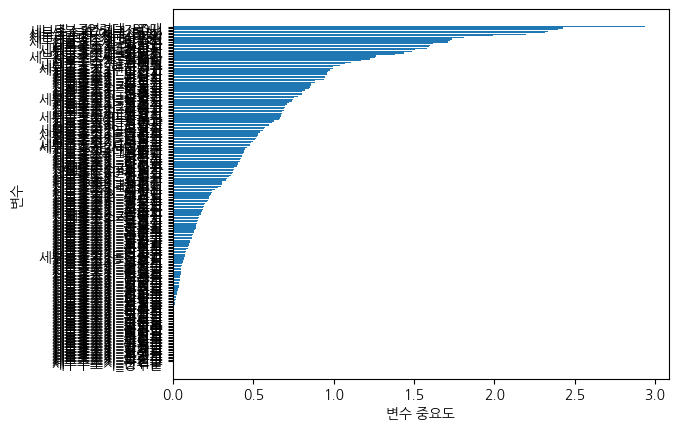

In [505]:
df_importance.sort_values("Importance",ascending=True, inplace=True)
coordinates = range(len(df_importance))
plt.barh(y=coordinates, width = df_importance["Importance"])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("변수 중요도")
plt.ylabel("변수")

In [506]:
from sklearn.metrics import classification_report
y_pred = tree_search.predict(df_train_x_over)
print('Train 예측/분류 결과')
print("Accuracy: {:.3f}\n".format(tree_search.score(df_train_x_over, df_train_y_over)))
print("Coufusion matrix: \n{}".format(confusion_matrix(df_train_y_over, y_pred)))

print(classification_report(df_train_y_over,y_pred,digits=3))

y_pred = tree_search.predict(df_test_x_over)
print('Test 예측/분류 결과')
print("Accuracy: {:.3f}\n".format(tree_search.score(df_test_x_over, df_test_y_over)))
print("Coufusion matrix: \n{}".format(confusion_matrix(df_test_y_over, y_pred)))

print(classification_report(df_test_y_over,y_pred,digits=3))

Train 예측/분류 결과
Accuracy: 0.935

Coufusion matrix: 
[[4622  192]
 [ 435 4378]]
              precision    recall  f1-score   support

           0      0.914     0.960     0.936      4814
           1      0.958     0.910     0.933      4813

    accuracy                          0.935      9627
   macro avg      0.936     0.935     0.935      9627
weighted avg      0.936     0.935     0.935      9627

Test 예측/분류 결과
Accuracy: 0.929

Coufusion matrix: 
[[1957  106]
 [ 185 1879]]
              precision    recall  f1-score   support

           0      0.914     0.949     0.931      2063
           1      0.947     0.910     0.928      2064

    accuracy                          0.929      4127
   macro avg      0.930     0.929     0.929      4127
weighted avg      0.930     0.929     0.929      4127



# lightgbm

In [17]:
from lightgbm import LGBMClassifier
dt_clf = LGBMClassifier(random_state=1)

param_dist = {
    'max_depth':[None,5,6,7],
    'n_estimators':[300,400]
    }

tree_search = GridSearchCV(dt_clf, param_dist, scoring = 'accuracy', refit=True)
tree_search.fit(df_train_x_over, df_train_y_over)

GridSearchCV(estimator=LGBMClassifier(random_state=1),
             param_grid={'max_depth': [None, 5, 6, 7],
                         'n_estimators': [300, 400]},
             scoring='accuracy')

In [18]:
print('best parameters : ', tree_search.best_params_)
print('best score : ', round(tree_search.best_score_, 4))

best parameters :  {'max_depth': None, 'n_estimators': 400}
best score :  0.8611


In [19]:
v_feature_name = df_train_x_over.columns

df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["Importance"] = tree_search.best_estimator_.feature_importances_
# feature_importances=grid_search.best_estimator_.feature_importances_
df_importance.sort_values("Importance", ascending=False, inplace=True)
df_importance.round(3)

,Feature,Importance
8,구독여부_False,697
1,연령대_30대,622
7,결혼_미혼,537
2,연령대_40대,515
5,결혼_기혼,398
...,...,...
97,세부주소지_삼척시,0
98,세부주소지_상주시,0
104,세부주소지_서귀포시,0
105,세부주소지_서대문구,0


In [20]:
from sklearn.metrics import classification_report
y_pred = tree_search.predict(df_train_x_over)
print('Train 예측/분류 결과')
print("Accuracy: {:.3f}\n".format(tree_search.score(df_train_x_over, df_train_y_over)))
print("Coufusion matrix: \n{}".format(confusion_matrix(df_train_y_over, y_pred)))

print(classification_report(df_train_y_over,y_pred,digits=3))

y_pred = tree_search.predict(df_test_x_over)
print('Test 예측/분류 결과')
print("Accuracy: {:.3f}\n".format(tree_search.score(df_test_x_over, df_test_y_over)))
print("Coufusion matrix: \n{}".format(confusion_matrix(df_test_y_over, y_pred)))

print(classification_report(df_test_y_over,y_pred,digits=3))

Train 예측/분류 결과
Accuracy: 0.899

Coufusion matrix: 
[[4093  721]
 [ 254 4559]]
              precision    recall  f1-score   support

           0      0.942     0.850     0.894      4814
           1      0.863     0.947     0.903      4813

    accuracy                          0.899      9627
   macro avg      0.903     0.899     0.898      9627
weighted avg      0.903     0.899     0.898      9627

Test 예측/분류 결과
Accuracy: 0.894

Coufusion matrix: 
[[1743  320]
 [ 118 1946]]
              precision    recall  f1-score   support

           0      0.937     0.845     0.888      2063
           1      0.859     0.943     0.899      2064

    accuracy                          0.894      4127
   macro avg      0.898     0.894     0.894      4127
weighted avg      0.898     0.894     0.894      4127

